In [1]:
# %% [markdown]
# # Fine-tuning DETR on Fashionpedia Dataset
# 
# This notebook demonstrates how to fine-tune the `facebook/detr-resnet-50` model on the Fashionpedia dataset for fashion object detection.
# 
# ## Overview
# - Load Fashionpedia dataset from Hugging Face
# - Create custom PyTorch dataset for COCO format data
# - Fine-tune DETR model
# - Evaluate and visualize results
# - Interactive inference demo

# ====================================
#  0. Install required packages
# ====================================

In [2]:
!pip install transformers datasets torch torchvision matplotlib pillow numpy tqdm accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 997.8 kB/s eta 0:00:00a 0:00:01
  Attempting un

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from transformers import DetrForObjectDetection, AutoProcessor
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import json
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

2025-08-27 06:40:20.132282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756276820.353462      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756276820.400744      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# ============================================
# 1. Load Fashionpedia Dataset
# ============================================

In [5]:
# Load the Fashionpedia dataset
print("Loading Fashionpedia dataset...")
dataset = load_dataset("detection-datasets/fashionpedia")

# Explore dataset structure
print(f"Dataset keys: {dataset.keys()}")
print(f"Train split size: {len(dataset['train'])}")

# Check if validation split exists, otherwise use test split
if 'validation' in dataset:
    val_split_name = 'validation'
    print(f"Validation split size: {len(dataset['validation'])}")
elif 'test' in dataset:
    val_split_name = 'test' 
    print(f"Test split size: {len(dataset['test'])}")
else:
    val_split_name = None
    print("No validation/test split found. Will create validation split from training data.")

# Look at a sample
sample = dataset['train'][0]
print(f"\nSample keys: {sample.keys()}")
print(f"Image shape: {np.array(sample['image']).shape}")
print(f"Number of objects: {len(sample['objects']['bbox'])}")


Loading Fashionpedia dataset...


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00007-fe108070118553(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00001-of-00007-f41a5a9c38c900(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00002-of-00007-40bc8456894bcb(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00003-of-00007-9a99ff8dc572e0(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00004-of-00007-f4e6f12cd2cedf(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00005-of-00007-41d8dfe1edb659(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00006-of-00007-f41b0f2f4bbefa(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/val-00000-of-00001-0b29e85429788213(…):   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

Dataset keys: dict_keys(['train', 'val'])
Train split size: 45623
No validation/test split found. Will create validation split from training data.

Sample keys: dict_keys(['image_id', 'image', 'width', 'height', 'objects'])
Image shape: (1024, 682, 3)
Number of objects: 4


In [6]:
# Get category information - inspect dataset structure first
print("Inspecting dataset structure...")
print(f"Dataset features: {dataset['train'].features}")
print(f"Objects feature type: {type(dataset['train'].features['objects'])}")

# Check the structure of objects
if hasattr(dataset['train'].features['objects'], 'feature'):
    print(f"Objects feature structure: {dataset['train'].features['objects'].feature}")

# Look at actual sample data to understand the category structure
sample = dataset['train'][0]
print(f"\nSample objects keys: {sample['objects'].keys()}")
if 'category' in sample['objects']:
    print(f"Category values in first sample: {sample['objects']['category']}")
    print(f"Category type: {type(sample['objects']['category'])}")


Inspecting dataset structure...
Dataset features: {'image_id': Value(dtype='int64', id=None), 'image': Image(mode=None, decode=True, id=None), 'width': Value(dtype='int64', id=None), 'height': Value(dtype='int64', id=None), 'objects': Sequence(feature={'bbox_id': Value(dtype='int64', id=None), 'category': ClassLabel(names=['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel'], id=None), 'bbox': Sequence(feature=Value(dtype='float64', id=None), length=4, id=None), 'area': Value(dtype='int64', id=None)}, length=-1, id=None)}
Objec

In [7]:
# Try different approaches to get categories
try:
    # Approach 1: Direct access to names
    categories = dataset['train'].features['objects']['category'].names
    print(f"Method 1 - Direct names access: Success")
except Exception as e:
    print(f"Method 1 failed: {e}")
    
    try:
        # Approach 2: Access through feature
        categories = dataset['train'].features['objects'].feature['category'].names
        print(f"Method 2 - Feature.names access: Success")
    except Exception as e:
        print(f"Method 2 failed: {e}")
        
        try:
            # Approach 3: Manual extraction from all samples
            print("Method 3 - Extracting categories from samples...")
            all_categories = set()
            for i, sample in enumerate(dataset['train']):
                if i > 100:  # Check first 100 samples for efficiency
                    break
                for cat in sample['objects']['category']:
                    all_categories.add(cat)
            categories = sorted(list(all_categories))
            print(f"Method 3 - Manual extraction: Found {len(categories)} categories")
        except Exception as e:
            print(f"Method 3 failed: {e}")
            # Fallback - use known Fashionpedia categories
            categories = [
                'shirt', 'top', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 
                'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband', 
                'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights', 'sock', 'shoe', 
                'bag', 'scarf', 'umbrella'
            ]
            print(f"Using fallback categories: {len(categories)} categories")

num_classes = len(categories)
print(f"Number of categories: {num_classes}")
print(f"First 10 categories: {categories[:10]}")

# Create id2label and label2id mappings
id2label = {i: categories[i] for i in range(num_classes)}
label2id = {categories[i]: i for i in range(num_classes)}


Method 1 failed: 'Sequence' object is not subscriptable
Method 2 - Feature.names access: Success
Number of categories: 46
First 10 categories: ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat']


# =======================================
# 2. Initialize Model and Processor
# =======================================

In [8]:
# Initialize processor and model
model_name = "facebook/detr-resnet-50"
print(f"Loading processor and model: {model_name}")

processor = AutoProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(
    model_name,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
model.to(device)

print(f"Model loaded successfully. Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


Loading processor and model: facebook/detr-resnet-50


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Model loaded successfully. Number of parameters: 41,513,203


# =============================================
# 3. Create Custom Dataset Class
# =============================================

In [9]:
class FashionpediaDataset(Dataset):
    def __init__(self, dataset_split, processor, transform=None):
        self.dataset = dataset_split
        self.processor = processor
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Get sample
        sample = self.dataset[idx]
        image = sample['image']
        objects = sample['objects']
        
        # Convert PIL image to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Extract bounding boxes and labels
        bboxes = objects['bbox']  # Already in COCO format [x, y, width, height]
        labels = objects['category']
        
        # Prepare target in valid COCO format for processor
        # DETR processor expects: bbox, category_id, area, iscrowd
        annotations = []
        for bbox, category_id in zip(bboxes, labels):
            x, y, w, h = bbox
            annotation = {
                "bbox": [x, y, w, h],  # COCO format [x, y, width, height]
                "category_id": int(category_id),
                "area": float(w * h),  # Calculate area from width * height
                "iscrowd": 0  # Assume no crowd annotations (standard for object detection)
            }
            annotations.append(annotation)
        
        target = {
            "image_id": int(idx),
            "annotations": annotations
        }
        
        # Process image and target - processor will handle COCO to DETR conversion
        encoding = self.processor(images=image, annotations=target, return_tensors="pt")
        
        # Remove batch dimension added by processor
        pixel_values = encoding["pixel_values"].squeeze(0)
        
        # Get the processed labels (processor converts COCO format to DETR format internally)
        if "labels" in encoding:
            labels = encoding["labels"][0]
        else:
            # Fallback - manually create labels structure (should not happen with correct COCO format)
            labels = {
                'class_labels': torch.tensor([ann["category_id"] for ann in annotations], dtype=torch.long),
                'boxes': torch.tensor([[x + w/2, y + h/2, w, h] for x, y, w, h in bboxes], dtype=torch.float32)
            }
        
        return {
            'pixel_values': pixel_values,
            'labels': labels
        }


In [10]:
# Create datasets
print("Creating datasets...")

# Handle validation split creation
if val_split_name:
    # Use existing validation/test split
    train_dataset = FashionpediaDataset(dataset['train'], processor)
    val_dataset = FashionpediaDataset(dataset[val_split_name], processor)
    print(f"Using existing '{val_split_name}' split for validation")
else:
    # Create validation split from training data (80/20 split)
    train_size = int(0.8 * len(dataset['train']))
    val_size = len(dataset['train']) - train_size
    
    train_split, val_split = torch.utils.data.random_split(
        range(len(dataset['train'])), 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create subset datasets
    train_subset = dataset['train'].select(train_split.indices)
    val_subset = dataset['train'].select(val_split.indices)
    
    train_dataset = FashionpediaDataset(train_subset, processor)
    val_dataset = FashionpediaDataset(val_subset, processor)
    print(f"Created validation split from training data (80/20 split)")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Creating datasets...
Created validation split from training data (80/20 split)
Train dataset size: 36498
Validation dataset size: 9125


In [11]:
# Custom collate function for DataLoader
def collate_fn(batch):
    """
    Custom collate function that handles batching of images with different sizes
    Works properly with DetrImageProcessor
    """
    # Extract pixel values and labels from batch
    pixel_values = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]
    
    # Method 1: Try using processor's pad method with proper format
    try:
        # The processor might expect pixel_values as a list of tensors
        # Let's try padding them directly
        if hasattr(processor, 'pad') and callable(getattr(processor, 'pad')):
            # Try different formats that the processor might expect
            try:
                # Format 1: Direct list of tensors
                padded = processor.pad(pixel_values, return_tensors="pt")
                return {
                    "pixel_values": padded["pixel_values"] if "pixel_values" in padded else padded,
                    "labels": labels
                }
            except:
                # Format 2: Wrapped in dict
                padded = processor.pad({"pixel_values": pixel_values}, return_tensors="pt")
                return {
                    "pixel_values": padded["pixel_values"],
                    "labels": labels
                }
        else:
            raise AttributeError("No pad method available")
            
    except Exception as e:
        # Method 2: Manual padding fallback
        # Check if all images are already the same size
        shapes = [pv.shape for pv in pixel_values]
        if len(set(shapes)) == 1:
            # All same size - can stack directly
            stacked_pixel_values = torch.stack(pixel_values)
        else:
            # Different sizes - manual padding
            # Find max dimensions
            max_height = max(pv.shape[1] for pv in pixel_values)
            max_width = max(pv.shape[2] for pv in pixel_values)
            
            # Pad each image to max dimensions
            padded_images = []
            for pv in pixel_values:
                # Calculate padding (pad_left, pad_right, pad_top, pad_bottom)
                pad_height = max_height - pv.shape[1]
                pad_width = max_width - pv.shape[2]
                
                # Pad with zeros (you can change padding value if needed)
                padded = torch.nn.functional.pad(
                    pv, 
                    (0, pad_width, 0, pad_height),  # (pad_left, pad_right, pad_top, pad_bottom)
                    mode='constant', 
                    value=0
                )
                padded_images.append(padded)
            
            stacked_pixel_values = torch.stack(padded_images)
        
        return {
            "pixel_values": stacked_pixel_values,
            "labels": labels
        }


In [12]:
# Create data loaders
batch_size = 4  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Test the dataset and data loader
print("Testing dataset and data loader with complete COCO annotations...")
try:
    # Test single sample
    test_sample = train_dataset[0]
    print(f"✅ Single sample test passed")
    print(f"   - Pixel values shape: {test_sample['pixel_values'].shape}")
    print(f"   - Labels type: {type(test_sample['labels'])}")
    if isinstance(test_sample['labels'], dict):
        print(f"   - Labels keys: {test_sample['labels'].keys()}")
        if 'class_labels' in test_sample['labels']:
            print(f"   - Number of objects: {len(test_sample['labels']['class_labels'])}")
        if 'boxes' in test_sample['labels']:
            print(f"   - Boxes shape: {test_sample['labels']['boxes'].shape}")
    
    # Test data loader batch
    test_batch = next(iter(train_loader))
    print(f"✅ Batch test passed")
    print(f"   - Batch pixel values shape: {test_batch['pixel_values'].shape}")
    print(f"   - Batch labels length: {len(test_batch['labels'])}")
    print(f"   - First batch item labels type: {type(test_batch['labels'][0])}")
    
    # Test forward pass with model (to catch any remaining issues)
    print("Testing forward pass with model...")
    pixel_values = test_batch['pixel_values'][:1]  # Take just one sample
    labels = test_batch['labels'][:1]
    
    with torch.no_grad():
        # Move to device if available
        if device.type == 'cuda':
            pixel_values = pixel_values.to(device)
            labels = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                      for k, v in label.items()} for label in labels]
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        print(f"✅ Model forward pass successful")
        print(f"   - Loss: {outputs.loss.item():.4f}")
    
    print("\n🎉 Dataset, DataLoader, and Model are working correctly!")
    print("Ready to start training!")
    
except Exception as e:
    print(f"❌ Error testing dataset: {e}")
    import traceback
    traceback.print_exc()

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Testing dataset and data loader with complete COCO annotations...
✅ Single sample test passed
   - Pixel values shape: torch.Size([3, 1199, 800])
   - Labels type: <class 'transformers.image_processing_base.BatchFeature'>
✅ Batch test passed
   - Batch pixel values shape: torch.Size([4, 3, 1333, 1201])
   - Batch labels length: 4
   - First batch item labels type: <class 'transformers.image_processing_base.BatchFeature'>
Testing forward pass with model...
✅ Model forward pass successful
   - Loss: 6.1001

🎉 Dataset, DataLoader, and Model are working correctly!
Ready to start training!
Training batches: 9125
Validation batches: 2282


# ===============================================
# 4. Training
# ===============================================


In [13]:
# Training configuration
num_epochs = 2  # Adjust as needed
learning_rate = 1e-5
weight_decay = 1e-4

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [14]:
# Training function
def train_one_epoch(model, train_loader, optimizer, device, epoch):
    model.train()
    total_loss = 0
    num_batches = len(train_loader)
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        # Move to device
        pixel_values = batch['pixel_values'].to(device)
        labels = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                  for k, v in label.items()} for label in batch['labels']]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        
        optimizer.step()
        
        total_loss += loss.item()
        
        # Print progress every 50 batches
        if (batch_idx + 1) % 50 == 0:
            avg_loss = total_loss / (batch_idx + 1)
            print(f"Batch {batch_idx+1}/{num_batches} | Loss: {loss.item():.4f} | Avg Loss: {avg_loss:.4f}")
    
    avg_epoch_loss = total_loss / num_batches
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss


In [15]:
# Validation function
def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    num_batches = len(val_loader)
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            pixel_values = batch['pixel_values'].to(device)
            labels = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                      for k, v in label.items()} for label in batch['labels']]
            
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    
    avg_loss = total_loss / num_batches
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss


In [16]:
# Training loop
print("Starting training...")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)
    
    # Update learning rate
    scheduler.step()
    
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    print("="*60)

print("Training completed!")


Starting training...

Epoch 1/2
--------------------------------------------------


Training Epoch 1:   1%|          | 50/9125 [00:41<2:03:05,  1.23it/s]

Batch 50/9125 | Loss: 6.8055 | Avg Loss: 7.2513


Training Epoch 1:   1%|          | 100/9125 [01:22<2:08:11,  1.17it/s]

Batch 100/9125 | Loss: 6.1441 | Avg Loss: 6.8591


Training Epoch 1:   2%|▏         | 150/9125 [02:02<1:53:03,  1.32it/s]

Batch 150/9125 | Loss: 5.1953 | Avg Loss: 6.4964


Training Epoch 1:   2%|▏         | 200/9125 [02:40<1:49:23,  1.36it/s]

Batch 200/9125 | Loss: 5.0418 | Avg Loss: 6.1740


Training Epoch 1:   3%|▎         | 250/9125 [03:20<2:07:26,  1.16it/s]

Batch 250/9125 | Loss: 4.0773 | Avg Loss: 5.8359


Training Epoch 1:   3%|▎         | 300/9125 [04:00<2:01:50,  1.21it/s]

Batch 300/9125 | Loss: 4.2369 | Avg Loss: 5.5069


Training Epoch 1:   4%|▍         | 350/9125 [04:39<1:58:28,  1.23it/s]

Batch 350/9125 | Loss: 3.4327 | Avg Loss: 5.2404


Training Epoch 1:   4%|▍         | 400/9125 [05:19<1:55:28,  1.26it/s]

Batch 400/9125 | Loss: 3.1764 | Avg Loss: 5.0260


Training Epoch 1:   5%|▍         | 450/9125 [05:58<1:51:41,  1.29it/s]

Batch 450/9125 | Loss: 3.9724 | Avg Loss: 4.8501


Training Epoch 1:   5%|▌         | 500/9125 [06:37<1:44:39,  1.37it/s]

Batch 500/9125 | Loss: 3.2759 | Avg Loss: 4.7008


Training Epoch 1:   6%|▌         | 550/9125 [07:15<1:50:23,  1.29it/s]

Batch 550/9125 | Loss: 2.9486 | Avg Loss: 4.5775


Training Epoch 1:   7%|▋         | 600/9125 [07:56<2:05:53,  1.13it/s]

Batch 600/9125 | Loss: 3.6672 | Avg Loss: 4.4700


Training Epoch 1:   7%|▋         | 650/9125 [08:35<1:46:53,  1.32it/s]

Batch 650/9125 | Loss: 2.9715 | Avg Loss: 4.3775


Training Epoch 1:   8%|▊         | 700/9125 [09:15<1:47:54,  1.30it/s]

Batch 700/9125 | Loss: 3.7434 | Avg Loss: 4.2933


Training Epoch 1:   8%|▊         | 750/9125 [09:55<1:47:29,  1.30it/s]

Batch 750/9125 | Loss: 3.7289 | Avg Loss: 4.2165


Training Epoch 1:   9%|▉         | 800/9125 [10:34<1:38:53,  1.40it/s]

Batch 800/9125 | Loss: 3.2902 | Avg Loss: 4.1524


Training Epoch 1:   9%|▉         | 850/9125 [11:15<1:49:23,  1.26it/s]

Batch 850/9125 | Loss: 3.3613 | Avg Loss: 4.0914


Training Epoch 1:  10%|▉         | 900/9125 [11:54<1:42:11,  1.34it/s]

Batch 900/9125 | Loss: 3.2393 | Avg Loss: 4.0355


Training Epoch 1:  10%|█         | 950/9125 [12:34<1:37:22,  1.40it/s]

Batch 950/9125 | Loss: 2.4307 | Avg Loss: 3.9868


Training Epoch 1:  11%|█         | 1000/9125 [13:13<1:37:58,  1.38it/s]

Batch 1000/9125 | Loss: 3.2603 | Avg Loss: 3.9401


Training Epoch 1:  12%|█▏        | 1050/9125 [13:54<1:45:52,  1.27it/s]

Batch 1050/9125 | Loss: 2.8481 | Avg Loss: 3.8977


Training Epoch 1:  12%|█▏        | 1100/9125 [14:33<1:55:07,  1.16it/s]

Batch 1100/9125 | Loss: 2.8638 | Avg Loss: 3.8570


Training Epoch 1:  13%|█▎        | 1150/9125 [15:10<1:49:36,  1.21it/s]

Batch 1150/9125 | Loss: 3.7449 | Avg Loss: 3.8177


Training Epoch 1:  13%|█▎        | 1200/9125 [15:51<1:49:51,  1.20it/s]

Batch 1200/9125 | Loss: 2.7050 | Avg Loss: 3.7790


Training Epoch 1:  14%|█▎        | 1250/9125 [16:30<1:40:44,  1.30it/s]

Batch 1250/9125 | Loss: 2.2998 | Avg Loss: 3.7460


Training Epoch 1:  14%|█▍        | 1300/9125 [17:11<1:41:12,  1.29it/s]

Batch 1300/9125 | Loss: 2.5334 | Avg Loss: 3.7142


Training Epoch 1:  15%|█▍        | 1350/9125 [17:51<1:45:46,  1.23it/s]

Batch 1350/9125 | Loss: 3.2776 | Avg Loss: 3.6864


Training Epoch 1:  15%|█▌        | 1400/9125 [18:31<1:36:49,  1.33it/s]

Batch 1400/9125 | Loss: 3.0836 | Avg Loss: 3.6607


Training Epoch 1:  16%|█▌        | 1450/9125 [19:09<1:32:20,  1.39it/s]

Batch 1450/9125 | Loss: 2.5810 | Avg Loss: 3.6346


Training Epoch 1:  16%|█▋        | 1500/9125 [19:48<1:41:15,  1.25it/s]

Batch 1500/9125 | Loss: 2.1559 | Avg Loss: 3.6119


Training Epoch 1:  17%|█▋        | 1550/9125 [20:28<1:45:45,  1.19it/s]

Batch 1550/9125 | Loss: 3.1756 | Avg Loss: 3.5886


Training Epoch 1:  18%|█▊        | 1600/9125 [21:08<1:46:06,  1.18it/s]

Batch 1600/9125 | Loss: 2.6190 | Avg Loss: 3.5654


Training Epoch 1:  18%|█▊        | 1650/9125 [21:46<1:36:21,  1.29it/s]

Batch 1650/9125 | Loss: 2.8760 | Avg Loss: 3.5440


Training Epoch 1:  19%|█▊        | 1700/9125 [22:26<1:38:00,  1.26it/s]

Batch 1700/9125 | Loss: 2.5671 | Avg Loss: 3.5223


Training Epoch 1:  19%|█▉        | 1750/9125 [23:05<1:39:43,  1.23it/s]

Batch 1750/9125 | Loss: 3.2456 | Avg Loss: 3.5037


Training Epoch 1:  20%|█▉        | 1800/9125 [23:44<1:46:10,  1.15it/s]

Batch 1800/9125 | Loss: 3.3638 | Avg Loss: 3.4868


Training Epoch 1:  20%|██        | 1850/9125 [24:24<1:34:38,  1.28it/s]

Batch 1850/9125 | Loss: 2.4953 | Avg Loss: 3.4695


Training Epoch 1:  21%|██        | 1900/9125 [25:02<1:26:04,  1.40it/s]

Batch 1900/9125 | Loss: 3.2072 | Avg Loss: 3.4530


Training Epoch 1:  21%|██▏       | 1950/9125 [25:41<1:43:48,  1.15it/s]

Batch 1950/9125 | Loss: 2.9638 | Avg Loss: 3.4404


Training Epoch 1:  22%|██▏       | 2000/9125 [26:21<1:45:43,  1.12it/s]

Batch 2000/9125 | Loss: 2.6969 | Avg Loss: 3.4246


Training Epoch 1:  22%|██▏       | 2050/9125 [26:59<1:36:12,  1.23it/s]

Batch 2050/9125 | Loss: 2.0334 | Avg Loss: 3.4108


Training Epoch 1:  23%|██▎       | 2100/9125 [27:39<1:35:50,  1.22it/s]

Batch 2100/9125 | Loss: 1.6821 | Avg Loss: 3.3959


Training Epoch 1:  24%|██▎       | 2150/9125 [28:18<1:34:22,  1.23it/s]

Batch 2150/9125 | Loss: 3.0074 | Avg Loss: 3.3820


Training Epoch 1:  24%|██▍       | 2200/9125 [28:58<1:43:15,  1.12it/s]

Batch 2200/9125 | Loss: 2.7633 | Avg Loss: 3.3692


Training Epoch 1:  25%|██▍       | 2250/9125 [29:38<1:27:39,  1.31it/s]

Batch 2250/9125 | Loss: 2.6274 | Avg Loss: 3.3560


Training Epoch 1:  25%|██▌       | 2300/9125 [30:19<1:26:05,  1.32it/s]

Batch 2300/9125 | Loss: 2.6068 | Avg Loss: 3.3431


Training Epoch 1:  26%|██▌       | 2350/9125 [30:59<1:36:36,  1.17it/s]

Batch 2350/9125 | Loss: 2.5558 | Avg Loss: 3.3284


Training Epoch 1:  26%|██▋       | 2400/9125 [31:40<1:27:13,  1.28it/s]

Batch 2400/9125 | Loss: 3.1141 | Avg Loss: 3.3170


Training Epoch 1:  27%|██▋       | 2450/9125 [32:21<1:24:50,  1.31it/s]

Batch 2450/9125 | Loss: 2.2105 | Avg Loss: 3.3038


Training Epoch 1:  27%|██▋       | 2500/9125 [33:02<1:30:23,  1.22it/s]

Batch 2500/9125 | Loss: 2.5989 | Avg Loss: 3.2902


Training Epoch 1:  28%|██▊       | 2550/9125 [33:41<1:33:35,  1.17it/s]

Batch 2550/9125 | Loss: 2.6415 | Avg Loss: 3.2782


Training Epoch 1:  28%|██▊       | 2600/9125 [34:21<1:22:11,  1.32it/s]

Batch 2600/9125 | Loss: 3.0612 | Avg Loss: 3.2682


Training Epoch 1:  29%|██▉       | 2650/9125 [35:03<1:37:53,  1.10it/s]

Batch 2650/9125 | Loss: 2.6685 | Avg Loss: 3.2561


Training Epoch 1:  30%|██▉       | 2700/9125 [35:41<1:16:55,  1.39it/s]

Batch 2700/9125 | Loss: 2.3204 | Avg Loss: 3.2451


Training Epoch 1:  30%|███       | 2750/9125 [36:21<1:21:45,  1.30it/s]

Batch 2750/9125 | Loss: 2.9282 | Avg Loss: 3.2340


Training Epoch 1:  31%|███       | 2800/9125 [37:00<1:21:33,  1.29it/s]

Batch 2800/9125 | Loss: 3.1666 | Avg Loss: 3.2238


Training Epoch 1:  31%|███       | 2850/9125 [37:40<1:15:38,  1.38it/s]

Batch 2850/9125 | Loss: 2.1241 | Avg Loss: 3.2141


Training Epoch 1:  32%|███▏      | 2900/9125 [38:21<1:28:04,  1.18it/s]

Batch 2900/9125 | Loss: 2.9835 | Avg Loss: 3.2053


Training Epoch 1:  32%|███▏      | 2950/9125 [39:02<1:29:58,  1.14it/s]

Batch 2950/9125 | Loss: 3.2137 | Avg Loss: 3.1954


Training Epoch 1:  33%|███▎      | 3000/9125 [39:43<1:25:17,  1.20it/s]

Batch 3000/9125 | Loss: 2.2230 | Avg Loss: 3.1854


Training Epoch 1:  33%|███▎      | 3050/9125 [40:23<1:20:02,  1.26it/s]

Batch 3050/9125 | Loss: 2.7217 | Avg Loss: 3.1768


Training Epoch 1:  34%|███▍      | 3100/9125 [41:04<1:28:44,  1.13it/s]

Batch 3100/9125 | Loss: 2.3365 | Avg Loss: 3.1671


Training Epoch 1:  35%|███▍      | 3150/9125 [41:44<1:26:37,  1.15it/s]

Batch 3150/9125 | Loss: 2.8234 | Avg Loss: 3.1592


Training Epoch 1:  35%|███▌      | 3200/9125 [42:25<1:30:21,  1.09it/s]

Batch 3200/9125 | Loss: 2.3941 | Avg Loss: 3.1509


Training Epoch 1:  36%|███▌      | 3250/9125 [43:04<1:23:47,  1.17it/s]

Batch 3250/9125 | Loss: 2.8516 | Avg Loss: 3.1418


Training Epoch 1:  36%|███▌      | 3300/9125 [43:43<1:14:38,  1.30it/s]

Batch 3300/9125 | Loss: 2.8142 | Avg Loss: 3.1334


Training Epoch 1:  37%|███▋      | 3350/9125 [44:24<1:19:37,  1.21it/s]

Batch 3350/9125 | Loss: 2.4021 | Avg Loss: 3.1259


Training Epoch 1:  37%|███▋      | 3400/9125 [45:03<1:14:12,  1.29it/s]

Batch 3400/9125 | Loss: 2.0478 | Avg Loss: 3.1159


Training Epoch 1:  38%|███▊      | 3450/9125 [45:43<1:23:49,  1.13it/s]

Batch 3450/9125 | Loss: 2.7523 | Avg Loss: 3.1074


Training Epoch 1:  38%|███▊      | 3500/9125 [46:24<1:20:56,  1.16it/s]

Batch 3500/9125 | Loss: 1.9432 | Avg Loss: 3.1006


Training Epoch 1:  39%|███▉      | 3550/9125 [47:05<1:14:43,  1.24it/s]

Batch 3550/9125 | Loss: 2.2270 | Avg Loss: 3.0939


Training Epoch 1:  39%|███▉      | 3600/9125 [47:44<1:14:49,  1.23it/s]

Batch 3600/9125 | Loss: 2.8469 | Avg Loss: 3.0872


Training Epoch 1:  40%|████      | 3650/9125 [48:25<1:11:37,  1.27it/s]

Batch 3650/9125 | Loss: 2.5256 | Avg Loss: 3.0794


Training Epoch 1:  41%|████      | 3700/9125 [49:05<1:19:12,  1.14it/s]

Batch 3700/9125 | Loss: 2.7265 | Avg Loss: 3.0719


Training Epoch 1:  41%|████      | 3750/9125 [49:44<1:09:02,  1.30it/s]

Batch 3750/9125 | Loss: 2.0722 | Avg Loss: 3.0640


Training Epoch 1:  42%|████▏     | 3800/9125 [50:22<1:02:42,  1.42it/s]

Batch 3800/9125 | Loss: 3.1288 | Avg Loss: 3.0579


Training Epoch 1:  42%|████▏     | 3850/9125 [51:03<1:12:11,  1.22it/s]

Batch 3850/9125 | Loss: 2.0050 | Avg Loss: 3.0510


Training Epoch 1:  43%|████▎     | 3900/9125 [51:42<1:00:57,  1.43it/s]

Batch 3900/9125 | Loss: 2.7813 | Avg Loss: 3.0447


Training Epoch 1:  43%|████▎     | 3950/9125 [52:22<1:06:25,  1.30it/s]

Batch 3950/9125 | Loss: 2.2314 | Avg Loss: 3.0381


Training Epoch 1:  44%|████▍     | 4000/9125 [53:03<1:18:15,  1.09it/s]

Batch 4000/9125 | Loss: 1.9919 | Avg Loss: 3.0321


Training Epoch 1:  44%|████▍     | 4050/9125 [53:43<1:00:02,  1.41it/s]

Batch 4050/9125 | Loss: 2.7710 | Avg Loss: 3.0248


Training Epoch 1:  45%|████▍     | 4100/9125 [54:24<1:10:29,  1.19it/s]

Batch 4100/9125 | Loss: 2.5033 | Avg Loss: 3.0195


Training Epoch 1:  45%|████▌     | 4150/9125 [55:04<1:00:46,  1.36it/s]

Batch 4150/9125 | Loss: 2.7235 | Avg Loss: 3.0133


Training Epoch 1:  46%|████▌     | 4200/9125 [55:43<1:09:50,  1.18it/s]

Batch 4200/9125 | Loss: 2.2686 | Avg Loss: 3.0069


Training Epoch 1:  47%|████▋     | 4250/9125 [56:23<1:01:02,  1.33it/s]

Batch 4250/9125 | Loss: 1.6220 | Avg Loss: 2.9997


Training Epoch 1:  47%|████▋     | 4300/9125 [57:03<1:03:35,  1.26it/s]

Batch 4300/9125 | Loss: 2.2937 | Avg Loss: 2.9920


Training Epoch 1:  48%|████▊     | 4350/9125 [57:43<1:03:26,  1.25it/s]

Batch 4350/9125 | Loss: 2.7237 | Avg Loss: 2.9853


Training Epoch 1:  48%|████▊     | 4400/9125 [58:23<1:02:13,  1.27it/s]

Batch 4400/9125 | Loss: 2.6940 | Avg Loss: 2.9791


Training Epoch 1:  49%|████▉     | 4450/9125 [59:04<1:04:30,  1.21it/s]

Batch 4450/9125 | Loss: 2.3887 | Avg Loss: 2.9737


Training Epoch 1:  49%|████▉     | 4500/9125 [59:45<58:47,  1.31it/s]  

Batch 4500/9125 | Loss: 1.9076 | Avg Loss: 2.9674


Training Epoch 1:  50%|████▉     | 4550/9125 [1:00:25<1:03:15,  1.21it/s]

Batch 4550/9125 | Loss: 2.4503 | Avg Loss: 2.9624


Training Epoch 1:  50%|█████     | 4600/9125 [1:01:04<54:29,  1.38it/s]  

Batch 4600/9125 | Loss: 2.4433 | Avg Loss: 2.9558


Training Epoch 1:  51%|█████     | 4650/9125 [1:01:45<1:01:53,  1.20it/s]

Batch 4650/9125 | Loss: 2.2741 | Avg Loss: 2.9508


Training Epoch 1:  52%|█████▏    | 4700/9125 [1:02:28<1:07:29,  1.09it/s]

Batch 4700/9125 | Loss: 1.9810 | Avg Loss: 2.9451


Training Epoch 1:  52%|█████▏    | 4750/9125 [1:03:10<1:05:28,  1.11it/s]

Batch 4750/9125 | Loss: 2.6750 | Avg Loss: 2.9398


Training Epoch 1:  53%|█████▎    | 4800/9125 [1:03:49<56:01,  1.29it/s]  

Batch 4800/9125 | Loss: 3.5764 | Avg Loss: 2.9339


Training Epoch 1:  53%|█████▎    | 4850/9125 [1:04:27<1:03:49,  1.12it/s]

Batch 4850/9125 | Loss: 3.1133 | Avg Loss: 2.9281


Training Epoch 1:  54%|█████▎    | 4900/9125 [1:05:08<1:03:30,  1.11it/s]

Batch 4900/9125 | Loss: 2.3585 | Avg Loss: 2.9229


Training Epoch 1:  54%|█████▍    | 4950/9125 [1:05:49<55:10,  1.26it/s]  

Batch 4950/9125 | Loss: 2.2856 | Avg Loss: 2.9167


Training Epoch 1:  55%|█████▍    | 5000/9125 [1:06:30<1:00:49,  1.13it/s]

Batch 5000/9125 | Loss: 2.5291 | Avg Loss: 2.9108


Training Epoch 1:  55%|█████▌    | 5050/9125 [1:07:11<1:00:56,  1.11it/s]

Batch 5050/9125 | Loss: 2.6705 | Avg Loss: 2.9058


Training Epoch 1:  56%|█████▌    | 5100/9125 [1:07:52<1:00:35,  1.11it/s]

Batch 5100/9125 | Loss: 2.1053 | Avg Loss: 2.9006


Training Epoch 1:  56%|█████▋    | 5150/9125 [1:08:33<57:03,  1.16it/s]  

Batch 5150/9125 | Loss: 2.2342 | Avg Loss: 2.8955


Training Epoch 1:  57%|█████▋    | 5200/9125 [1:09:14<52:36,  1.24it/s]  

Batch 5200/9125 | Loss: 2.8723 | Avg Loss: 2.8909


Training Epoch 1:  58%|█████▊    | 5250/9125 [1:09:54<55:36,  1.16it/s]

Batch 5250/9125 | Loss: 2.7703 | Avg Loss: 2.8861


Training Epoch 1:  58%|█████▊    | 5300/9125 [1:10:35<52:59,  1.20it/s]

Batch 5300/9125 | Loss: 2.1366 | Avg Loss: 2.8806


Training Epoch 1:  59%|█████▊    | 5350/9125 [1:11:16<51:07,  1.23it/s]  

Batch 5350/9125 | Loss: 1.6953 | Avg Loss: 2.8740


Training Epoch 1:  59%|█████▉    | 5400/9125 [1:11:56<47:36,  1.30it/s]

Batch 5400/9125 | Loss: 2.3578 | Avg Loss: 2.8689


Training Epoch 1:  60%|█████▉    | 5450/9125 [1:12:36<50:34,  1.21it/s]

Batch 5450/9125 | Loss: 2.4330 | Avg Loss: 2.8641


Training Epoch 1:  60%|██████    | 5500/9125 [1:13:18<50:57,  1.19it/s]

Batch 5500/9125 | Loss: 3.5254 | Avg Loss: 2.8584


Training Epoch 1:  61%|██████    | 5550/9125 [1:13:59<47:33,  1.25it/s]

Batch 5550/9125 | Loss: 2.3092 | Avg Loss: 2.8534


Training Epoch 1:  61%|██████▏   | 5600/9125 [1:14:39<48:51,  1.20it/s]

Batch 5600/9125 | Loss: 2.1389 | Avg Loss: 2.8487


Training Epoch 1:  62%|██████▏   | 5650/9125 [1:15:20<42:06,  1.38it/s]

Batch 5650/9125 | Loss: 2.2440 | Avg Loss: 2.8445


Training Epoch 1:  62%|██████▏   | 5700/9125 [1:15:58<41:44,  1.37it/s]

Batch 5700/9125 | Loss: 2.4696 | Avg Loss: 2.8396


Training Epoch 1:  63%|██████▎   | 5750/9125 [1:16:37<44:46,  1.26it/s]

Batch 5750/9125 | Loss: 2.5307 | Avg Loss: 2.8346


Training Epoch 1:  64%|██████▎   | 5800/9125 [1:17:16<50:40,  1.09it/s]

Batch 5800/9125 | Loss: 1.8910 | Avg Loss: 2.8296


Training Epoch 1:  64%|██████▍   | 5850/9125 [1:17:55<43:24,  1.26it/s]

Batch 5850/9125 | Loss: 2.4413 | Avg Loss: 2.8247


Training Epoch 1:  65%|██████▍   | 5900/9125 [1:18:35<39:58,  1.34it/s]

Batch 5900/9125 | Loss: 1.9101 | Avg Loss: 2.8198


Training Epoch 1:  65%|██████▌   | 5950/9125 [1:19:14<41:45,  1.27it/s]

Batch 5950/9125 | Loss: 2.4867 | Avg Loss: 2.8155


Training Epoch 1:  66%|██████▌   | 6000/9125 [1:19:54<39:14,  1.33it/s]

Batch 6000/9125 | Loss: 1.7826 | Avg Loss: 2.8103


Training Epoch 1:  66%|██████▋   | 6050/9125 [1:20:34<36:58,  1.39it/s]

Batch 6050/9125 | Loss: 2.5292 | Avg Loss: 2.8052


Training Epoch 1:  67%|██████▋   | 6100/9125 [1:21:15<38:45,  1.30it/s]

Batch 6100/9125 | Loss: 1.8447 | Avg Loss: 2.8010


Training Epoch 1:  67%|██████▋   | 6150/9125 [1:21:54<37:20,  1.33it/s]

Batch 6150/9125 | Loss: 2.1982 | Avg Loss: 2.7964


Training Epoch 1:  68%|██████▊   | 6200/9125 [1:22:34<38:38,  1.26it/s]

Batch 6200/9125 | Loss: 2.5078 | Avg Loss: 2.7920


Training Epoch 1:  68%|██████▊   | 6250/9125 [1:23:14<37:27,  1.28it/s]

Batch 6250/9125 | Loss: 2.5108 | Avg Loss: 2.7875


Training Epoch 1:  69%|██████▉   | 6300/9125 [1:23:53<33:58,  1.39it/s]

Batch 6300/9125 | Loss: 2.0537 | Avg Loss: 2.7827


Training Epoch 1:  70%|██████▉   | 6350/9125 [1:24:34<40:18,  1.15it/s]

Batch 6350/9125 | Loss: 2.2344 | Avg Loss: 2.7783


Training Epoch 1:  70%|███████   | 6400/9125 [1:25:14<38:06,  1.19it/s]

Batch 6400/9125 | Loss: 2.2895 | Avg Loss: 2.7736


Training Epoch 1:  71%|███████   | 6450/9125 [1:25:54<38:17,  1.16it/s]

Batch 6450/9125 | Loss: 2.2044 | Avg Loss: 2.7686


Training Epoch 1:  71%|███████   | 6500/9125 [1:26:34<33:26,  1.31it/s]

Batch 6500/9125 | Loss: 1.8239 | Avg Loss: 2.7645


Training Epoch 1:  72%|███████▏  | 6550/9125 [1:27:12<33:31,  1.28it/s]

Batch 6550/9125 | Loss: 2.2684 | Avg Loss: 2.7603


Training Epoch 1:  72%|███████▏  | 6600/9125 [1:27:54<36:36,  1.15it/s]

Batch 6600/9125 | Loss: 2.1520 | Avg Loss: 2.7565


Training Epoch 1:  73%|███████▎  | 6650/9125 [1:28:33<30:19,  1.36it/s]

Batch 6650/9125 | Loss: 1.9154 | Avg Loss: 2.7524


Training Epoch 1:  73%|███████▎  | 6700/9125 [1:29:14<30:32,  1.32it/s]

Batch 6700/9125 | Loss: 1.9350 | Avg Loss: 2.7478


Training Epoch 1:  74%|███████▍  | 6750/9125 [1:29:52<28:32,  1.39it/s]

Batch 6750/9125 | Loss: 2.5473 | Avg Loss: 2.7444


Training Epoch 1:  75%|███████▍  | 6800/9125 [1:30:32<30:19,  1.28it/s]

Batch 6800/9125 | Loss: 2.0941 | Avg Loss: 2.7400


Training Epoch 1:  75%|███████▌  | 6850/9125 [1:31:13<30:34,  1.24it/s]

Batch 6850/9125 | Loss: 2.3223 | Avg Loss: 2.7354


Training Epoch 1:  76%|███████▌  | 6900/9125 [1:31:52<27:12,  1.36it/s]

Batch 6900/9125 | Loss: 1.9893 | Avg Loss: 2.7314


Training Epoch 1:  76%|███████▌  | 6950/9125 [1:32:33<30:50,  1.18it/s]

Batch 6950/9125 | Loss: 2.1596 | Avg Loss: 2.7275


Training Epoch 1:  77%|███████▋  | 7000/9125 [1:33:12<30:42,  1.15it/s]

Batch 7000/9125 | Loss: 2.1808 | Avg Loss: 2.7241


Training Epoch 1:  77%|███████▋  | 7050/9125 [1:33:51<24:33,  1.41it/s]

Batch 7050/9125 | Loss: 2.3694 | Avg Loss: 2.7197


Training Epoch 1:  78%|███████▊  | 7100/9125 [1:34:31<28:12,  1.20it/s]

Batch 7100/9125 | Loss: 1.8426 | Avg Loss: 2.7147


Training Epoch 1:  78%|███████▊  | 7150/9125 [1:35:12<27:13,  1.21it/s]

Batch 7150/9125 | Loss: 2.2001 | Avg Loss: 2.7112


Training Epoch 1:  79%|███████▉  | 7200/9125 [1:35:52<25:19,  1.27it/s]

Batch 7200/9125 | Loss: 1.6195 | Avg Loss: 2.7077


Training Epoch 1:  79%|███████▉  | 7250/9125 [1:36:33<24:13,  1.29it/s]

Batch 7250/9125 | Loss: 2.0018 | Avg Loss: 2.7034


Training Epoch 1:  80%|████████  | 7300/9125 [1:37:14<22:59,  1.32it/s]

Batch 7300/9125 | Loss: 1.9069 | Avg Loss: 2.6996


Training Epoch 1:  81%|████████  | 7350/9125 [1:37:55<24:54,  1.19it/s]

Batch 7350/9125 | Loss: 1.6884 | Avg Loss: 2.6958


Training Epoch 1:  81%|████████  | 7400/9125 [1:38:35<21:49,  1.32it/s]

Batch 7400/9125 | Loss: 2.2100 | Avg Loss: 2.6912


Training Epoch 1:  82%|████████▏ | 7450/9125 [1:39:17<23:44,  1.18it/s]

Batch 7450/9125 | Loss: 2.2137 | Avg Loss: 2.6875


Training Epoch 1:  82%|████████▏ | 7500/9125 [1:39:57<23:02,  1.18it/s]

Batch 7500/9125 | Loss: 1.4974 | Avg Loss: 2.6832


Training Epoch 1:  83%|████████▎ | 7550/9125 [1:40:37<21:58,  1.19it/s]

Batch 7550/9125 | Loss: 1.9869 | Avg Loss: 2.6792


Training Epoch 1:  83%|████████▎ | 7600/9125 [1:41:18<19:51,  1.28it/s]

Batch 7600/9125 | Loss: 1.8312 | Avg Loss: 2.6748


Training Epoch 1:  84%|████████▍ | 7650/9125 [1:41:56<18:45,  1.31it/s]

Batch 7650/9125 | Loss: 1.1612 | Avg Loss: 2.6710


Training Epoch 1:  84%|████████▍ | 7700/9125 [1:42:36<20:32,  1.16it/s]

Batch 7700/9125 | Loss: 2.1570 | Avg Loss: 2.6674


Training Epoch 1:  85%|████████▍ | 7750/9125 [1:43:16<19:35,  1.17it/s]

Batch 7750/9125 | Loss: 2.1620 | Avg Loss: 2.6637


Training Epoch 1:  85%|████████▌ | 7800/9125 [1:43:54<18:11,  1.21it/s]

Batch 7800/9125 | Loss: 1.6594 | Avg Loss: 2.6596


Training Epoch 1:  86%|████████▌ | 7850/9125 [1:44:35<17:28,  1.22it/s]

Batch 7850/9125 | Loss: 2.3235 | Avg Loss: 2.6555


Training Epoch 1:  87%|████████▋ | 7900/9125 [1:45:15<15:48,  1.29it/s]

Batch 7900/9125 | Loss: 2.3019 | Avg Loss: 2.6521


Training Epoch 1:  87%|████████▋ | 7950/9125 [1:45:55<17:19,  1.13it/s]

Batch 7950/9125 | Loss: 1.6500 | Avg Loss: 2.6486


Training Epoch 1:  88%|████████▊ | 8000/9125 [1:46:35<14:52,  1.26it/s]

Batch 8000/9125 | Loss: 1.7417 | Avg Loss: 2.6445


Training Epoch 1:  88%|████████▊ | 8050/9125 [1:47:14<13:53,  1.29it/s]

Batch 8050/9125 | Loss: 2.3057 | Avg Loss: 2.6413


Training Epoch 1:  89%|████████▉ | 8100/9125 [1:47:54<12:41,  1.35it/s]

Batch 8100/9125 | Loss: 1.7965 | Avg Loss: 2.6378


Training Epoch 1:  89%|████████▉ | 8150/9125 [1:48:34<12:30,  1.30it/s]

Batch 8150/9125 | Loss: 2.4711 | Avg Loss: 2.6343


Training Epoch 1:  90%|████████▉ | 8200/9125 [1:49:14<13:02,  1.18it/s]

Batch 8200/9125 | Loss: 1.9223 | Avg Loss: 2.6314


Training Epoch 1:  90%|█████████ | 8250/9125 [1:49:54<12:51,  1.13it/s]

Batch 8250/9125 | Loss: 1.8724 | Avg Loss: 2.6277


Training Epoch 1:  91%|█████████ | 8300/9125 [1:50:33<11:04,  1.24it/s]

Batch 8300/9125 | Loss: 1.9087 | Avg Loss: 2.6241


Training Epoch 1:  92%|█████████▏| 8350/9125 [1:51:13<09:54,  1.30it/s]

Batch 8350/9125 | Loss: 1.4547 | Avg Loss: 2.6208


Training Epoch 1:  92%|█████████▏| 8400/9125 [1:51:55<09:31,  1.27it/s]

Batch 8400/9125 | Loss: 1.9882 | Avg Loss: 2.6182


Training Epoch 1:  93%|█████████▎| 8450/9125 [1:52:34<07:51,  1.43it/s]

Batch 8450/9125 | Loss: 1.7600 | Avg Loss: 2.6143


Training Epoch 1:  93%|█████████▎| 8500/9125 [1:53:14<08:53,  1.17it/s]

Batch 8500/9125 | Loss: 1.9969 | Avg Loss: 2.6105


Training Epoch 1:  94%|█████████▎| 8550/9125 [1:53:52<07:23,  1.30it/s]

Batch 8550/9125 | Loss: 1.5675 | Avg Loss: 2.6065


Training Epoch 1:  94%|█████████▍| 8600/9125 [1:54:32<07:35,  1.15it/s]

Batch 8600/9125 | Loss: 2.0479 | Avg Loss: 2.6032


Training Epoch 1:  95%|█████████▍| 8650/9125 [1:55:12<06:31,  1.21it/s]

Batch 8650/9125 | Loss: 1.5911 | Avg Loss: 2.5996


Training Epoch 1:  95%|█████████▌| 8700/9125 [1:55:51<05:37,  1.26it/s]

Batch 8700/9125 | Loss: 2.7748 | Avg Loss: 2.5961


Training Epoch 1:  96%|█████████▌| 8750/9125 [1:56:31<04:50,  1.29it/s]

Batch 8750/9125 | Loss: 1.4138 | Avg Loss: 2.5926


Training Epoch 1:  96%|█████████▋| 8800/9125 [1:57:12<04:02,  1.34it/s]

Batch 8800/9125 | Loss: 2.0138 | Avg Loss: 2.5893


Training Epoch 1:  97%|█████████▋| 8850/9125 [1:57:52<03:54,  1.17it/s]

Batch 8850/9125 | Loss: 1.9127 | Avg Loss: 2.5862


Training Epoch 1:  98%|█████████▊| 8900/9125 [1:58:33<03:00,  1.24it/s]

Batch 8900/9125 | Loss: 2.1902 | Avg Loss: 2.5824


Training Epoch 1:  98%|█████████▊| 8950/9125 [1:59:13<02:18,  1.27it/s]

Batch 8950/9125 | Loss: 2.1592 | Avg Loss: 2.5789


Training Epoch 1:  99%|█████████▊| 9000/9125 [1:59:54<01:35,  1.30it/s]

Batch 9000/9125 | Loss: 1.6652 | Avg Loss: 2.5752


Training Epoch 1:  99%|█████████▉| 9050/9125 [2:00:37<01:02,  1.19it/s]

Batch 9050/9125 | Loss: 2.0983 | Avg Loss: 2.5716


Training Epoch 1: 100%|█████████▉| 9100/9125 [2:01:17<00:21,  1.18it/s]

Batch 9100/9125 | Loss: 2.2508 | Avg Loss: 2.5684


Training Epoch 1: 100%|██████████| 9125/9125 [2:01:37<00:00,  1.25it/s]


Epoch 1 Average Loss: 2.5669


Validation: 100%|██████████| 2282/2282 [19:23<00:00,  1.96it/s]


Validation Loss: 1.9204
Learning Rate: 0.000010

Epoch 2/2
--------------------------------------------------


Training Epoch 2:   1%|          | 50/9125 [00:39<1:58:04,  1.28it/s]

Batch 50/9125 | Loss: 1.9014 | Avg Loss: 1.9467


Training Epoch 2:   1%|          | 100/9125 [01:19<1:59:14,  1.26it/s]

Batch 100/9125 | Loss: 2.3033 | Avg Loss: 1.9204


Training Epoch 2:   2%|▏         | 150/9125 [01:59<1:57:14,  1.28it/s]

Batch 150/9125 | Loss: 2.5083 | Avg Loss: 1.9172


Training Epoch 2:   2%|▏         | 200/9125 [02:39<1:46:31,  1.40it/s]

Batch 200/9125 | Loss: 1.7632 | Avg Loss: 1.9316


Training Epoch 2:   3%|▎         | 250/9125 [03:19<1:44:51,  1.41it/s]

Batch 250/9125 | Loss: 1.6426 | Avg Loss: 1.9406


Training Epoch 2:   3%|▎         | 300/9125 [03:59<2:00:47,  1.22it/s]

Batch 300/9125 | Loss: 2.2040 | Avg Loss: 1.9293


Training Epoch 2:   4%|▍         | 350/9125 [04:37<1:48:34,  1.35it/s]

Batch 350/9125 | Loss: 1.9083 | Avg Loss: 1.9241


Training Epoch 2:   4%|▍         | 400/9125 [05:15<1:55:36,  1.26it/s]

Batch 400/9125 | Loss: 2.3412 | Avg Loss: 1.9170


Training Epoch 2:   5%|▍         | 450/9125 [05:55<1:44:16,  1.39it/s]

Batch 450/9125 | Loss: 1.5479 | Avg Loss: 1.9191


Training Epoch 2:   5%|▌         | 500/9125 [06:34<1:44:17,  1.38it/s]

Batch 500/9125 | Loss: 1.6449 | Avg Loss: 1.9216


Training Epoch 2:   6%|▌         | 550/9125 [07:13<1:49:49,  1.30it/s]

Batch 550/9125 | Loss: 2.1833 | Avg Loss: 1.9146


Training Epoch 2:   7%|▋         | 600/9125 [07:53<2:02:00,  1.16it/s]

Batch 600/9125 | Loss: 1.7690 | Avg Loss: 1.9155


Training Epoch 2:   7%|▋         | 650/9125 [08:32<1:52:03,  1.26it/s]

Batch 650/9125 | Loss: 1.8047 | Avg Loss: 1.9110


Training Epoch 2:   8%|▊         | 700/9125 [09:13<1:48:53,  1.29it/s]

Batch 700/9125 | Loss: 2.0939 | Avg Loss: 1.9101


Training Epoch 2:   8%|▊         | 750/9125 [09:52<1:44:31,  1.34it/s]

Batch 750/9125 | Loss: 1.4542 | Avg Loss: 1.9027


Training Epoch 2:   9%|▉         | 800/9125 [10:32<1:41:54,  1.36it/s]

Batch 800/9125 | Loss: 2.3093 | Avg Loss: 1.9094


Training Epoch 2:   9%|▉         | 850/9125 [11:12<1:54:20,  1.21it/s]

Batch 850/9125 | Loss: 1.6055 | Avg Loss: 1.9061


Training Epoch 2:  10%|▉         | 900/9125 [11:52<1:55:51,  1.18it/s]

Batch 900/9125 | Loss: 1.6038 | Avg Loss: 1.9069


Training Epoch 2:  10%|█         | 950/9125 [12:31<1:41:33,  1.34it/s]

Batch 950/9125 | Loss: 1.4114 | Avg Loss: 1.9032


Training Epoch 2:  11%|█         | 1000/9125 [13:12<1:56:00,  1.17it/s]

Batch 1000/9125 | Loss: 1.5890 | Avg Loss: 1.9018


Training Epoch 2:  12%|█▏        | 1050/9125 [13:53<1:36:53,  1.39it/s]

Batch 1050/9125 | Loss: 1.5169 | Avg Loss: 1.8982


Training Epoch 2:  12%|█▏        | 1100/9125 [14:33<1:54:44,  1.17it/s]

Batch 1100/9125 | Loss: 2.0069 | Avg Loss: 1.8985


Training Epoch 2:  13%|█▎        | 1150/9125 [15:12<1:36:51,  1.37it/s]

Batch 1150/9125 | Loss: 1.5695 | Avg Loss: 1.8970


Training Epoch 2:  13%|█▎        | 1200/9125 [15:52<1:47:19,  1.23it/s]

Batch 1200/9125 | Loss: 2.3923 | Avg Loss: 1.8943


Training Epoch 2:  14%|█▎        | 1250/9125 [16:32<1:45:25,  1.25it/s]

Batch 1250/9125 | Loss: 1.8641 | Avg Loss: 1.8943


Training Epoch 2:  14%|█▍        | 1300/9125 [17:13<1:43:39,  1.26it/s]

Batch 1300/9125 | Loss: 1.9300 | Avg Loss: 1.8969


Training Epoch 2:  15%|█▍        | 1350/9125 [17:54<1:51:41,  1.16it/s]

Batch 1350/9125 | Loss: 2.0592 | Avg Loss: 1.9006


Training Epoch 2:  15%|█▌        | 1400/9125 [18:34<1:50:39,  1.16it/s]

Batch 1400/9125 | Loss: 2.1605 | Avg Loss: 1.9035


Training Epoch 2:  16%|█▌        | 1450/9125 [19:13<1:40:05,  1.28it/s]

Batch 1450/9125 | Loss: 1.2778 | Avg Loss: 1.9037


Training Epoch 2:  16%|█▋        | 1500/9125 [19:52<1:35:39,  1.33it/s]

Batch 1500/9125 | Loss: 1.6255 | Avg Loss: 1.8983


Training Epoch 2:  17%|█▋        | 1550/9125 [20:33<1:33:11,  1.35it/s]

Batch 1550/9125 | Loss: 1.7507 | Avg Loss: 1.8984


Training Epoch 2:  18%|█▊        | 1600/9125 [21:13<1:55:48,  1.08it/s]

Batch 1600/9125 | Loss: 1.7856 | Avg Loss: 1.8971


Training Epoch 2:  18%|█▊        | 1650/9125 [21:52<1:36:37,  1.29it/s]

Batch 1650/9125 | Loss: 1.7037 | Avg Loss: 1.8932


Training Epoch 2:  19%|█▊        | 1700/9125 [22:33<1:38:43,  1.25it/s]

Batch 1700/9125 | Loss: 2.1636 | Avg Loss: 1.8911


Training Epoch 2:  19%|█▉        | 1750/9125 [23:14<1:47:18,  1.15it/s]

Batch 1750/9125 | Loss: 1.8762 | Avg Loss: 1.8894


Training Epoch 2:  20%|█▉        | 1800/9125 [23:53<1:42:57,  1.19it/s]

Batch 1800/9125 | Loss: 2.3964 | Avg Loss: 1.8877


Training Epoch 2:  20%|██        | 1850/9125 [24:32<1:33:45,  1.29it/s]

Batch 1850/9125 | Loss: 2.0504 | Avg Loss: 1.8878


Training Epoch 2:  21%|██        | 1900/9125 [25:11<1:28:42,  1.36it/s]

Batch 1900/9125 | Loss: 1.7495 | Avg Loss: 1.8851


Training Epoch 2:  21%|██▏       | 1950/9125 [25:51<1:30:10,  1.33it/s]

Batch 1950/9125 | Loss: 1.8043 | Avg Loss: 1.8833


Training Epoch 2:  22%|██▏       | 2000/9125 [26:33<1:38:50,  1.20it/s]

Batch 2000/9125 | Loss: 1.5554 | Avg Loss: 1.8799


Training Epoch 2:  22%|██▏       | 2050/9125 [27:12<1:37:11,  1.21it/s]

Batch 2050/9125 | Loss: 1.8651 | Avg Loss: 1.8773


Training Epoch 2:  23%|██▎       | 2100/9125 [27:53<1:40:12,  1.17it/s]

Batch 2100/9125 | Loss: 1.4773 | Avg Loss: 1.8769


Training Epoch 2:  24%|██▎       | 2150/9125 [28:32<1:30:41,  1.28it/s]

Batch 2150/9125 | Loss: 1.8844 | Avg Loss: 1.8745


Training Epoch 2:  24%|██▍       | 2200/9125 [29:12<1:35:31,  1.21it/s]

Batch 2200/9125 | Loss: 1.9098 | Avg Loss: 1.8733


Training Epoch 2:  25%|██▍       | 2250/9125 [29:52<1:37:37,  1.17it/s]

Batch 2250/9125 | Loss: 1.5331 | Avg Loss: 1.8708


Training Epoch 2:  25%|██▌       | 2300/9125 [30:33<1:25:01,  1.34it/s]

Batch 2300/9125 | Loss: 2.0649 | Avg Loss: 1.8692


Training Epoch 2:  26%|██▌       | 2350/9125 [31:13<1:21:03,  1.39it/s]

Batch 2350/9125 | Loss: 2.1215 | Avg Loss: 1.8670


Training Epoch 2:  26%|██▋       | 2400/9125 [31:54<1:23:36,  1.34it/s]

Batch 2400/9125 | Loss: 2.0326 | Avg Loss: 1.8649


Training Epoch 2:  27%|██▋       | 2450/9125 [32:33<1:18:20,  1.42it/s]

Batch 2450/9125 | Loss: 1.2491 | Avg Loss: 1.8636


Training Epoch 2:  27%|██▋       | 2500/9125 [33:12<1:26:44,  1.27it/s]

Batch 2500/9125 | Loss: 1.7089 | Avg Loss: 1.8628


Training Epoch 2:  28%|██▊       | 2550/9125 [33:50<1:20:40,  1.36it/s]

Batch 2550/9125 | Loss: 1.6147 | Avg Loss: 1.8606


Training Epoch 2:  28%|██▊       | 2600/9125 [34:30<1:28:50,  1.22it/s]

Batch 2600/9125 | Loss: 1.9440 | Avg Loss: 1.8598


Training Epoch 2:  29%|██▉       | 2650/9125 [35:11<1:22:39,  1.31it/s]

Batch 2650/9125 | Loss: 1.5218 | Avg Loss: 1.8595


Training Epoch 2:  30%|██▉       | 2700/9125 [35:52<1:24:33,  1.27it/s]

Batch 2700/9125 | Loss: 2.0002 | Avg Loss: 1.8577


Training Epoch 2:  30%|███       | 2750/9125 [36:31<1:28:20,  1.20it/s]

Batch 2750/9125 | Loss: 1.3087 | Avg Loss: 1.8555


Training Epoch 2:  31%|███       | 2800/9125 [37:12<1:24:06,  1.25it/s]

Batch 2800/9125 | Loss: 1.6686 | Avg Loss: 1.8531


Training Epoch 2:  31%|███       | 2850/9125 [37:52<1:19:40,  1.31it/s]

Batch 2850/9125 | Loss: 1.6482 | Avg Loss: 1.8527


Training Epoch 2:  32%|███▏      | 2900/9125 [38:32<1:15:17,  1.38it/s]

Batch 2900/9125 | Loss: 1.5317 | Avg Loss: 1.8501


Training Epoch 2:  32%|███▏      | 2950/9125 [39:12<1:31:59,  1.12it/s]

Batch 2950/9125 | Loss: 1.8065 | Avg Loss: 1.8490


Training Epoch 2:  33%|███▎      | 3000/9125 [39:51<1:12:17,  1.41it/s]

Batch 3000/9125 | Loss: 1.5573 | Avg Loss: 1.8480


Training Epoch 2:  33%|███▎      | 3050/9125 [40:30<1:12:05,  1.40it/s]

Batch 3050/9125 | Loss: 3.8701 | Avg Loss: 1.8471


Training Epoch 2:  34%|███▍      | 3100/9125 [41:11<1:20:51,  1.24it/s]

Batch 3100/9125 | Loss: 1.0660 | Avg Loss: 1.8451


Training Epoch 2:  35%|███▍      | 3150/9125 [41:52<1:23:37,  1.19it/s]

Batch 3150/9125 | Loss: 1.4261 | Avg Loss: 1.8448


Training Epoch 2:  35%|███▌      | 3200/9125 [42:31<1:13:45,  1.34it/s]

Batch 3200/9125 | Loss: 1.7346 | Avg Loss: 1.8444


Training Epoch 2:  36%|███▌      | 3250/9125 [43:12<1:18:20,  1.25it/s]

Batch 3250/9125 | Loss: 2.4905 | Avg Loss: 1.8438


Training Epoch 2:  36%|███▌      | 3300/9125 [43:53<1:17:40,  1.25it/s]

Batch 3300/9125 | Loss: 1.3356 | Avg Loss: 1.8409


Training Epoch 2:  37%|███▋      | 3350/9125 [44:33<1:11:55,  1.34it/s]

Batch 3350/9125 | Loss: 1.7634 | Avg Loss: 1.8400


Training Epoch 2:  37%|███▋      | 3400/9125 [45:11<1:10:01,  1.36it/s]

Batch 3400/9125 | Loss: 1.8386 | Avg Loss: 1.8389


Training Epoch 2:  38%|███▊      | 3450/9125 [45:52<1:16:38,  1.23it/s]

Batch 3450/9125 | Loss: 1.5846 | Avg Loss: 1.8374


Training Epoch 2:  38%|███▊      | 3500/9125 [46:32<1:07:14,  1.39it/s]

Batch 3500/9125 | Loss: 1.8239 | Avg Loss: 1.8369


Training Epoch 2:  39%|███▉      | 3550/9125 [47:12<1:15:19,  1.23it/s]

Batch 3550/9125 | Loss: 1.1322 | Avg Loss: 1.8352


Training Epoch 2:  39%|███▉      | 3600/9125 [47:49<1:04:38,  1.42it/s]

Batch 3600/9125 | Loss: 1.3325 | Avg Loss: 1.8328


Training Epoch 2:  40%|████      | 3650/9125 [48:30<1:10:52,  1.29it/s]

Batch 3650/9125 | Loss: 1.7907 | Avg Loss: 1.8306


Training Epoch 2:  41%|████      | 3700/9125 [49:09<1:06:25,  1.36it/s]

Batch 3700/9125 | Loss: 1.3067 | Avg Loss: 1.8290


Training Epoch 2:  41%|████      | 3750/9125 [49:47<1:04:45,  1.38it/s]

Batch 3750/9125 | Loss: 1.1092 | Avg Loss: 1.8266


Training Epoch 2:  42%|████▏     | 3800/9125 [50:28<1:12:23,  1.23it/s]

Batch 3800/9125 | Loss: 2.0055 | Avg Loss: 1.8258


Training Epoch 2:  42%|████▏     | 3850/9125 [51:09<1:09:29,  1.27it/s]

Batch 3850/9125 | Loss: 1.5869 | Avg Loss: 1.8250


Training Epoch 2:  43%|████▎     | 3900/9125 [51:47<1:03:04,  1.38it/s]

Batch 3900/9125 | Loss: 1.9696 | Avg Loss: 1.8245


Training Epoch 2:  43%|████▎     | 3950/9125 [52:28<1:13:54,  1.17it/s]

Batch 3950/9125 | Loss: 1.8129 | Avg Loss: 1.8231


Training Epoch 2:  44%|████▍     | 4000/9125 [53:10<1:08:48,  1.24it/s]

Batch 4000/9125 | Loss: 1.4857 | Avg Loss: 1.8214


Training Epoch 2:  44%|████▍     | 4050/9125 [53:47<1:09:06,  1.22it/s]

Batch 4050/9125 | Loss: 1.4912 | Avg Loss: 1.8197


Training Epoch 2:  45%|████▍     | 4100/9125 [54:29<1:12:19,  1.16it/s]

Batch 4100/9125 | Loss: 1.7499 | Avg Loss: 1.8182


Training Epoch 2:  45%|████▌     | 4150/9125 [55:09<1:03:22,  1.31it/s]

Batch 4150/9125 | Loss: 1.4684 | Avg Loss: 1.8173


Training Epoch 2:  46%|████▌     | 4200/9125 [55:50<1:03:40,  1.29it/s]

Batch 4200/9125 | Loss: 1.3893 | Avg Loss: 1.8156


Training Epoch 2:  47%|████▋     | 4250/9125 [56:31<57:28,  1.41it/s]  

Batch 4250/9125 | Loss: 2.3237 | Avg Loss: 1.8143


Training Epoch 2:  47%|████▋     | 4300/9125 [57:12<1:12:57,  1.10it/s]

Batch 4300/9125 | Loss: 2.0081 | Avg Loss: 1.8125


Training Epoch 2:  48%|████▊     | 4350/9125 [57:51<55:50,  1.43it/s]  

Batch 4350/9125 | Loss: 1.4843 | Avg Loss: 1.8114


Training Epoch 2:  48%|████▊     | 4400/9125 [58:34<1:03:42,  1.24it/s]

Batch 4400/9125 | Loss: 1.4200 | Avg Loss: 1.8102


Training Epoch 2:  49%|████▉     | 4450/9125 [59:13<1:02:40,  1.24it/s]

Batch 4450/9125 | Loss: 1.6697 | Avg Loss: 1.8087


Training Epoch 2:  49%|████▉     | 4500/9125 [59:54<1:09:09,  1.11it/s]

Batch 4500/9125 | Loss: 1.5496 | Avg Loss: 1.8076


Training Epoch 2:  50%|████▉     | 4550/9125 [1:00:36<56:47,  1.34it/s]  

Batch 4550/9125 | Loss: 1.8540 | Avg Loss: 1.8067


Training Epoch 2:  50%|█████     | 4600/9125 [1:01:14<56:20,  1.34it/s]  

Batch 4600/9125 | Loss: 2.0241 | Avg Loss: 1.8051


Training Epoch 2:  51%|█████     | 4650/9125 [1:01:53<59:26,  1.25it/s]  

Batch 4650/9125 | Loss: 1.6115 | Avg Loss: 1.8031


Training Epoch 2:  52%|█████▏    | 4700/9125 [1:02:34<1:07:16,  1.10it/s]

Batch 4700/9125 | Loss: 1.1805 | Avg Loss: 1.8020


Training Epoch 2:  52%|█████▏    | 4750/9125 [1:03:15<54:42,  1.33it/s]  

Batch 4750/9125 | Loss: 1.6001 | Avg Loss: 1.8003


Training Epoch 2:  53%|█████▎    | 4800/9125 [1:03:56<54:20,  1.33it/s]  

Batch 4800/9125 | Loss: 1.4149 | Avg Loss: 1.7988


Training Epoch 2:  53%|█████▎    | 4850/9125 [1:04:38<58:27,  1.22it/s]  

Batch 4850/9125 | Loss: 1.2360 | Avg Loss: 1.7977


Training Epoch 2:  54%|█████▎    | 4900/9125 [1:05:17<55:31,  1.27it/s]  

Batch 4900/9125 | Loss: 2.2735 | Avg Loss: 1.7960


Training Epoch 2:  54%|█████▍    | 4950/9125 [1:05:56<53:40,  1.30it/s]  

Batch 4950/9125 | Loss: 1.2161 | Avg Loss: 1.7943


Training Epoch 2:  55%|█████▍    | 5000/9125 [1:06:35<59:04,  1.16it/s]  

Batch 5000/9125 | Loss: 1.4239 | Avg Loss: 1.7929


Training Epoch 2:  55%|█████▌    | 5050/9125 [1:07:16<1:01:41,  1.10it/s]

Batch 5050/9125 | Loss: 1.7582 | Avg Loss: 1.7925


Training Epoch 2:  56%|█████▌    | 5100/9125 [1:07:58<53:00,  1.27it/s]  

Batch 5100/9125 | Loss: 1.3359 | Avg Loss: 1.7906


Training Epoch 2:  56%|█████▋    | 5150/9125 [1:08:38<52:20,  1.27it/s]

Batch 5150/9125 | Loss: 1.6255 | Avg Loss: 1.7892


Training Epoch 2:  57%|█████▋    | 5200/9125 [1:09:18<49:37,  1.32it/s]  

Batch 5200/9125 | Loss: 1.7793 | Avg Loss: 1.7874


Training Epoch 2:  58%|█████▊    | 5250/9125 [1:09:59<49:40,  1.30it/s]

Batch 5250/9125 | Loss: 1.7733 | Avg Loss: 1.7862


Training Epoch 2:  58%|█████▊    | 5300/9125 [1:10:40<50:58,  1.25it/s]

Batch 5300/9125 | Loss: 1.4019 | Avg Loss: 1.7843


Training Epoch 2:  59%|█████▊    | 5350/9125 [1:11:19<46:29,  1.35it/s]

Batch 5350/9125 | Loss: 1.7167 | Avg Loss: 1.7825


Training Epoch 2:  59%|█████▉    | 5400/9125 [1:11:59<45:16,  1.37it/s]

Batch 5400/9125 | Loss: 1.5604 | Avg Loss: 1.7811


Training Epoch 2:  60%|█████▉    | 5450/9125 [1:12:40<56:37,  1.08it/s]

Batch 5450/9125 | Loss: 1.8198 | Avg Loss: 1.7809


Training Epoch 2:  60%|██████    | 5500/9125 [1:13:20<57:54,  1.04it/s]

Batch 5500/9125 | Loss: 2.1605 | Avg Loss: 1.7805


Training Epoch 2:  61%|██████    | 5550/9125 [1:14:00<47:37,  1.25it/s]

Batch 5550/9125 | Loss: 1.6426 | Avg Loss: 1.7792


Training Epoch 2:  61%|██████▏   | 5600/9125 [1:14:41<54:46,  1.07it/s]

Batch 5600/9125 | Loss: 1.8132 | Avg Loss: 1.7786


Training Epoch 2:  62%|██████▏   | 5650/9125 [1:15:21<47:46,  1.21it/s]

Batch 5650/9125 | Loss: 1.8650 | Avg Loss: 1.7770


Training Epoch 2:  62%|██████▏   | 5700/9125 [1:16:01<41:59,  1.36it/s]

Batch 5700/9125 | Loss: 1.2188 | Avg Loss: 1.7757


Training Epoch 2:  63%|██████▎   | 5750/9125 [1:16:41<47:03,  1.20it/s]

Batch 5750/9125 | Loss: 1.3614 | Avg Loss: 1.7748


Training Epoch 2:  64%|██████▎   | 5800/9125 [1:17:21<43:56,  1.26it/s]

Batch 5800/9125 | Loss: 1.6335 | Avg Loss: 1.7738


Training Epoch 2:  64%|██████▍   | 5850/9125 [1:18:02<49:28,  1.10it/s]

Batch 5850/9125 | Loss: 1.6941 | Avg Loss: 1.7725


Training Epoch 2:  65%|██████▍   | 5900/9125 [1:18:42<39:28,  1.36it/s]

Batch 5900/9125 | Loss: 1.5831 | Avg Loss: 1.7717


Training Epoch 2:  65%|██████▌   | 5950/9125 [1:19:22<38:50,  1.36it/s]

Batch 5950/9125 | Loss: 1.5516 | Avg Loss: 1.7702


Training Epoch 2:  66%|██████▌   | 6000/9125 [1:20:02<41:01,  1.27it/s]

Batch 6000/9125 | Loss: 1.4178 | Avg Loss: 1.7686


Training Epoch 2:  66%|██████▋   | 6050/9125 [1:20:43<41:36,  1.23it/s]

Batch 6050/9125 | Loss: 1.2398 | Avg Loss: 1.7667


Training Epoch 2:  67%|██████▋   | 6100/9125 [1:21:23<42:19,  1.19it/s]

Batch 6100/9125 | Loss: 2.5536 | Avg Loss: 1.7664


Training Epoch 2:  67%|██████▋   | 6150/9125 [1:22:05<42:23,  1.17it/s]

Batch 6150/9125 | Loss: 1.4923 | Avg Loss: 1.7657


Training Epoch 2:  68%|██████▊   | 6200/9125 [1:22:45<41:09,  1.18it/s]

Batch 6200/9125 | Loss: 1.7705 | Avg Loss: 1.7647


Training Epoch 2:  68%|██████▊   | 6250/9125 [1:23:26<38:35,  1.24it/s]

Batch 6250/9125 | Loss: 2.0682 | Avg Loss: 1.7638


Training Epoch 2:  69%|██████▉   | 6300/9125 [1:24:06<38:08,  1.23it/s]

Batch 6300/9125 | Loss: 0.8333 | Avg Loss: 1.7627


Training Epoch 2:  70%|██████▉   | 6350/9125 [1:24:45<36:48,  1.26it/s]

Batch 6350/9125 | Loss: 1.1311 | Avg Loss: 1.7615


Training Epoch 2:  70%|███████   | 6400/9125 [1:25:27<37:56,  1.20it/s]

Batch 6400/9125 | Loss: 1.8026 | Avg Loss: 1.7608


Training Epoch 2:  71%|███████   | 6450/9125 [1:26:07<40:58,  1.09it/s]

Batch 6450/9125 | Loss: 1.4755 | Avg Loss: 1.7597


Training Epoch 2:  71%|███████   | 6500/9125 [1:26:48<33:05,  1.32it/s]

Batch 6500/9125 | Loss: 1.7511 | Avg Loss: 1.7591


Training Epoch 2:  72%|███████▏  | 6550/9125 [1:27:28<35:33,  1.21it/s]

Batch 6550/9125 | Loss: 1.5110 | Avg Loss: 1.7578


Training Epoch 2:  72%|███████▏  | 6600/9125 [1:28:10<37:32,  1.12it/s]

Batch 6600/9125 | Loss: 1.1851 | Avg Loss: 1.7563


Training Epoch 2:  73%|███████▎  | 6650/9125 [1:28:50<35:00,  1.18it/s]

Batch 6650/9125 | Loss: 1.5760 | Avg Loss: 1.7555


Training Epoch 2:  73%|███████▎  | 6700/9125 [1:29:32<34:54,  1.16it/s]

Batch 6700/9125 | Loss: 2.0652 | Avg Loss: 1.7552


Training Epoch 2:  74%|███████▍  | 6750/9125 [1:30:10<29:42,  1.33it/s]

Batch 6750/9125 | Loss: 1.0257 | Avg Loss: 1.7543


Training Epoch 2:  75%|███████▍  | 6800/9125 [1:30:50<33:15,  1.16it/s]

Batch 6800/9125 | Loss: 1.0895 | Avg Loss: 1.7532


Training Epoch 2:  75%|███████▌  | 6850/9125 [1:31:31<36:07,  1.05it/s]

Batch 6850/9125 | Loss: 1.8689 | Avg Loss: 1.7522


Training Epoch 2:  76%|███████▌  | 6900/9125 [1:32:11<29:16,  1.27it/s]

Batch 6900/9125 | Loss: 1.6596 | Avg Loss: 1.7514


Training Epoch 2:  76%|███████▌  | 6950/9125 [1:32:51<27:15,  1.33it/s]

Batch 6950/9125 | Loss: 1.1364 | Avg Loss: 1.7502


Training Epoch 2:  77%|███████▋  | 7000/9125 [1:33:32<30:30,  1.16it/s]

Batch 7000/9125 | Loss: 1.7169 | Avg Loss: 1.7486


Training Epoch 2:  77%|███████▋  | 7050/9125 [1:34:13<28:01,  1.23it/s]

Batch 7050/9125 | Loss: 1.2327 | Avg Loss: 1.7472


Training Epoch 2:  78%|███████▊  | 7100/9125 [1:34:54<25:54,  1.30it/s]

Batch 7100/9125 | Loss: 2.0407 | Avg Loss: 1.7463


Training Epoch 2:  78%|███████▊  | 7150/9125 [1:35:34<28:06,  1.17it/s]

Batch 7150/9125 | Loss: 1.6864 | Avg Loss: 1.7454


Training Epoch 2:  79%|███████▉  | 7200/9125 [1:36:13<25:31,  1.26it/s]

Batch 7200/9125 | Loss: 1.2221 | Avg Loss: 1.7439


Training Epoch 2:  79%|███████▉  | 7250/9125 [1:36:52<25:08,  1.24it/s]

Batch 7250/9125 | Loss: 1.4580 | Avg Loss: 1.7424


Training Epoch 2:  80%|████████  | 7300/9125 [1:37:31<22:53,  1.33it/s]

Batch 7300/9125 | Loss: 0.9473 | Avg Loss: 1.7412


Training Epoch 2:  81%|████████  | 7350/9125 [1:38:12<23:08,  1.28it/s]

Batch 7350/9125 | Loss: 0.8155 | Avg Loss: 1.7399


Training Epoch 2:  81%|████████  | 7400/9125 [1:38:52<22:39,  1.27it/s]

Batch 7400/9125 | Loss: 1.1818 | Avg Loss: 1.7390


Training Epoch 2:  82%|████████▏ | 7450/9125 [1:39:31<21:09,  1.32it/s]

Batch 7450/9125 | Loss: 1.2632 | Avg Loss: 1.7377


Training Epoch 2:  82%|████████▏ | 7500/9125 [1:40:11<20:04,  1.35it/s]

Batch 7500/9125 | Loss: 1.4773 | Avg Loss: 1.7364


Training Epoch 2:  83%|████████▎ | 7550/9125 [1:40:51<22:10,  1.18it/s]

Batch 7550/9125 | Loss: 1.2848 | Avg Loss: 1.7357


Training Epoch 2:  83%|████████▎ | 7600/9125 [1:41:30<18:13,  1.39it/s]

Batch 7600/9125 | Loss: 1.5567 | Avg Loss: 1.7347


Training Epoch 2:  84%|████████▍ | 7650/9125 [1:42:09<18:22,  1.34it/s]

Batch 7650/9125 | Loss: 1.4051 | Avg Loss: 1.7336


Training Epoch 2:  84%|████████▍ | 7700/9125 [1:42:49<19:46,  1.20it/s]

Batch 7700/9125 | Loss: 2.0648 | Avg Loss: 1.7327


Training Epoch 2:  85%|████████▍ | 7750/9125 [1:43:28<18:39,  1.23it/s]

Batch 7750/9125 | Loss: 2.2197 | Avg Loss: 1.7328


Training Epoch 2:  85%|████████▌ | 7800/9125 [1:44:10<19:12,  1.15it/s]

Batch 7800/9125 | Loss: 1.8783 | Avg Loss: 1.7320


Training Epoch 2:  86%|████████▌ | 7850/9125 [1:44:49<16:58,  1.25it/s]

Batch 7850/9125 | Loss: 1.2020 | Avg Loss: 1.7311


Training Epoch 2:  87%|████████▋ | 7900/9125 [1:45:28<18:28,  1.11it/s]

Batch 7900/9125 | Loss: 1.6587 | Avg Loss: 1.7294


Training Epoch 2:  87%|████████▋ | 7950/9125 [1:46:08<15:41,  1.25it/s]

Batch 7950/9125 | Loss: 2.3427 | Avg Loss: 1.7290


Training Epoch 2:  88%|████████▊ | 8000/9125 [1:46:46<13:18,  1.41it/s]

Batch 8000/9125 | Loss: 0.8799 | Avg Loss: 1.7279


Training Epoch 2:  88%|████████▊ | 8050/9125 [1:47:24<13:49,  1.30it/s]

Batch 8050/9125 | Loss: 1.0647 | Avg Loss: 1.7261


Training Epoch 2:  89%|████████▉ | 8100/9125 [1:48:04<14:09,  1.21it/s]

Batch 8100/9125 | Loss: 1.4429 | Avg Loss: 1.7246


Training Epoch 2:  89%|████████▉ | 8150/9125 [1:48:43<13:46,  1.18it/s]

Batch 8150/9125 | Loss: 1.3295 | Avg Loss: 1.7242


Training Epoch 2:  90%|████████▉ | 8200/9125 [1:49:24<11:32,  1.34it/s]

Batch 8200/9125 | Loss: 1.2489 | Avg Loss: 1.7230


Training Epoch 2:  90%|█████████ | 8250/9125 [1:50:04<13:25,  1.09it/s]

Batch 8250/9125 | Loss: 1.6097 | Avg Loss: 1.7212


Training Epoch 2:  91%|█████████ | 8300/9125 [1:50:44<10:49,  1.27it/s]

Batch 8300/9125 | Loss: 2.0081 | Avg Loss: 1.7198


Training Epoch 2:  92%|█████████▏| 8350/9125 [1:51:22<10:19,  1.25it/s]

Batch 8350/9125 | Loss: 1.5949 | Avg Loss: 1.7181


Training Epoch 2:  92%|█████████▏| 8400/9125 [1:52:01<09:32,  1.27it/s]

Batch 8400/9125 | Loss: 1.7156 | Avg Loss: 1.7170


Training Epoch 2:  93%|█████████▎| 8450/9125 [1:52:40<08:13,  1.37it/s]

Batch 8450/9125 | Loss: 1.3723 | Avg Loss: 1.7161


Training Epoch 2:  93%|█████████▎| 8500/9125 [1:53:21<08:38,  1.21it/s]

Batch 8500/9125 | Loss: 1.3024 | Avg Loss: 1.7150


Training Epoch 2:  94%|█████████▎| 8550/9125 [1:54:00<07:22,  1.30it/s]

Batch 8550/9125 | Loss: 1.8356 | Avg Loss: 1.7138


Training Epoch 2:  94%|█████████▍| 8600/9125 [1:54:41<07:31,  1.16it/s]

Batch 8600/9125 | Loss: 0.9452 | Avg Loss: 1.7130


Training Epoch 2:  95%|█████████▍| 8650/9125 [1:55:19<05:26,  1.46it/s]

Batch 8650/9125 | Loss: 1.0352 | Avg Loss: 1.7115


Training Epoch 2:  95%|█████████▌| 8700/9125 [1:55:57<05:33,  1.27it/s]

Batch 8700/9125 | Loss: 2.1017 | Avg Loss: 1.7102


Training Epoch 2:  96%|█████████▌| 8750/9125 [1:56:37<05:07,  1.22it/s]

Batch 8750/9125 | Loss: 1.7748 | Avg Loss: 1.7089


Training Epoch 2:  96%|█████████▋| 8800/9125 [1:57:17<04:09,  1.30it/s]

Batch 8800/9125 | Loss: 1.1230 | Avg Loss: 1.7079


Training Epoch 2:  97%|█████████▋| 8850/9125 [1:57:58<03:31,  1.30it/s]

Batch 8850/9125 | Loss: 1.8211 | Avg Loss: 1.7073


Training Epoch 2:  98%|█████████▊| 8900/9125 [1:58:38<02:40,  1.41it/s]

Batch 8900/9125 | Loss: 1.6643 | Avg Loss: 1.7060


Training Epoch 2:  98%|█████████▊| 8950/9125 [1:59:17<02:25,  1.20it/s]

Batch 8950/9125 | Loss: 2.5223 | Avg Loss: 1.7047


Training Epoch 2:  99%|█████████▊| 9000/9125 [1:59:57<01:40,  1.24it/s]

Batch 9000/9125 | Loss: 1.5153 | Avg Loss: 1.7038


Training Epoch 2:  99%|█████████▉| 9050/9125 [2:00:36<01:00,  1.24it/s]

Batch 9050/9125 | Loss: 1.1689 | Avg Loss: 1.7026


Training Epoch 2: 100%|█████████▉| 9100/9125 [2:01:16<00:19,  1.26it/s]

Batch 9100/9125 | Loss: 1.4080 | Avg Loss: 1.7014


Training Epoch 2: 100%|██████████| 9125/9125 [2:01:36<00:00,  1.25it/s]


Epoch 2 Average Loss: 1.7009


Validation: 100%|██████████| 2282/2282 [19:33<00:00,  1.95it/s]

Validation Loss: 1.4649
Learning Rate: 0.000010
Training completed!


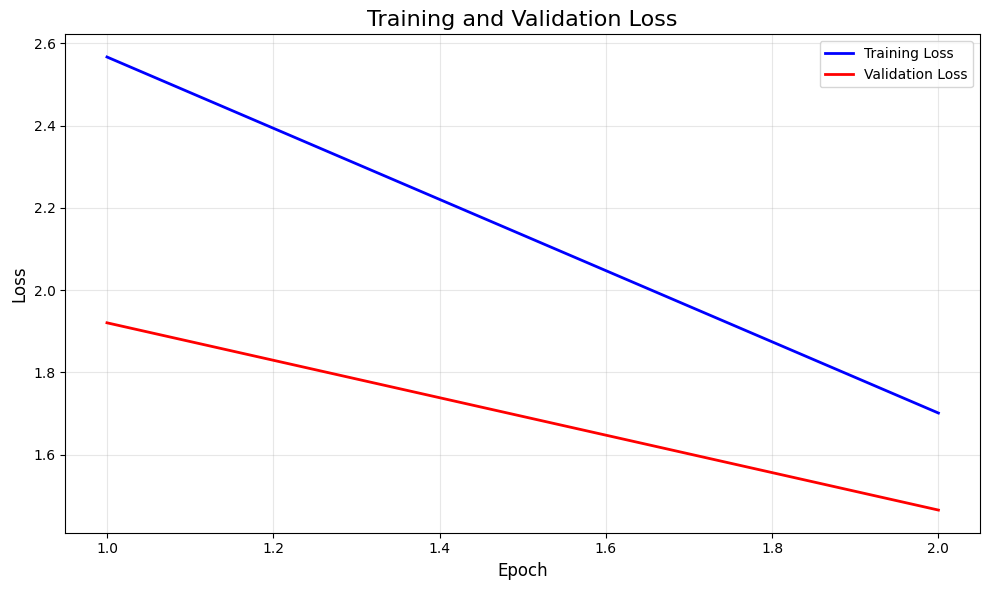

In [17]:
# Plot training curves
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 5. Model Evaluation and Visualization
# ============================================


In [18]:
# Visualization functions
def visualize_predictions(image, predictions, threshold=0.7):
    """Visualize predictions on an image"""
    # Convert tensor to PIL if needed
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)
    
    # Create a copy for drawing
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)
    
    # Get predictions above threshold
    scores = predictions['scores']
    labels = predictions['labels']
    boxes = predictions['boxes']
    
    # Filter by threshold
    keep = scores > threshold
    scores = scores[keep]
    labels = labels[keep]
    boxes = boxes[keep]
    
    # Draw bounding boxes
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    for score, label, box in zip(scores, labels, boxes):
        # Convert normalized coordinates to pixel coordinates
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Choose color
        color = colors[label.item() % len(colors)]
        
        # Draw bounding box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        
        # Draw label and score
        label_text = f"{id2label[label.item()]}: {score:.2f}"
        
        # Calculate text size and position
        bbox = draw.textbbox((0, 0), label_text)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        
        # Draw background for text
        draw.rectangle([x1, y1-text_height-5, x1+text_width+10, y1], fill=color)
        draw.text((x1+5, y1-text_height-2), label_text, fill='white')
    
    return draw_image

def predict_and_visualize(model, image, processor, device, threshold=0.7):
    """Make predictions on an image and visualize results"""
    model.eval()
    
    # Preprocess image
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Process outputs
    target_sizes = torch.tensor([image.size[::-1]]).to(device)  # (height, width)
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]
    
    # Visualize
    viz_image = visualize_predictions(image, results, threshold)
    
    return results, viz_image


Testing model on validation samples...


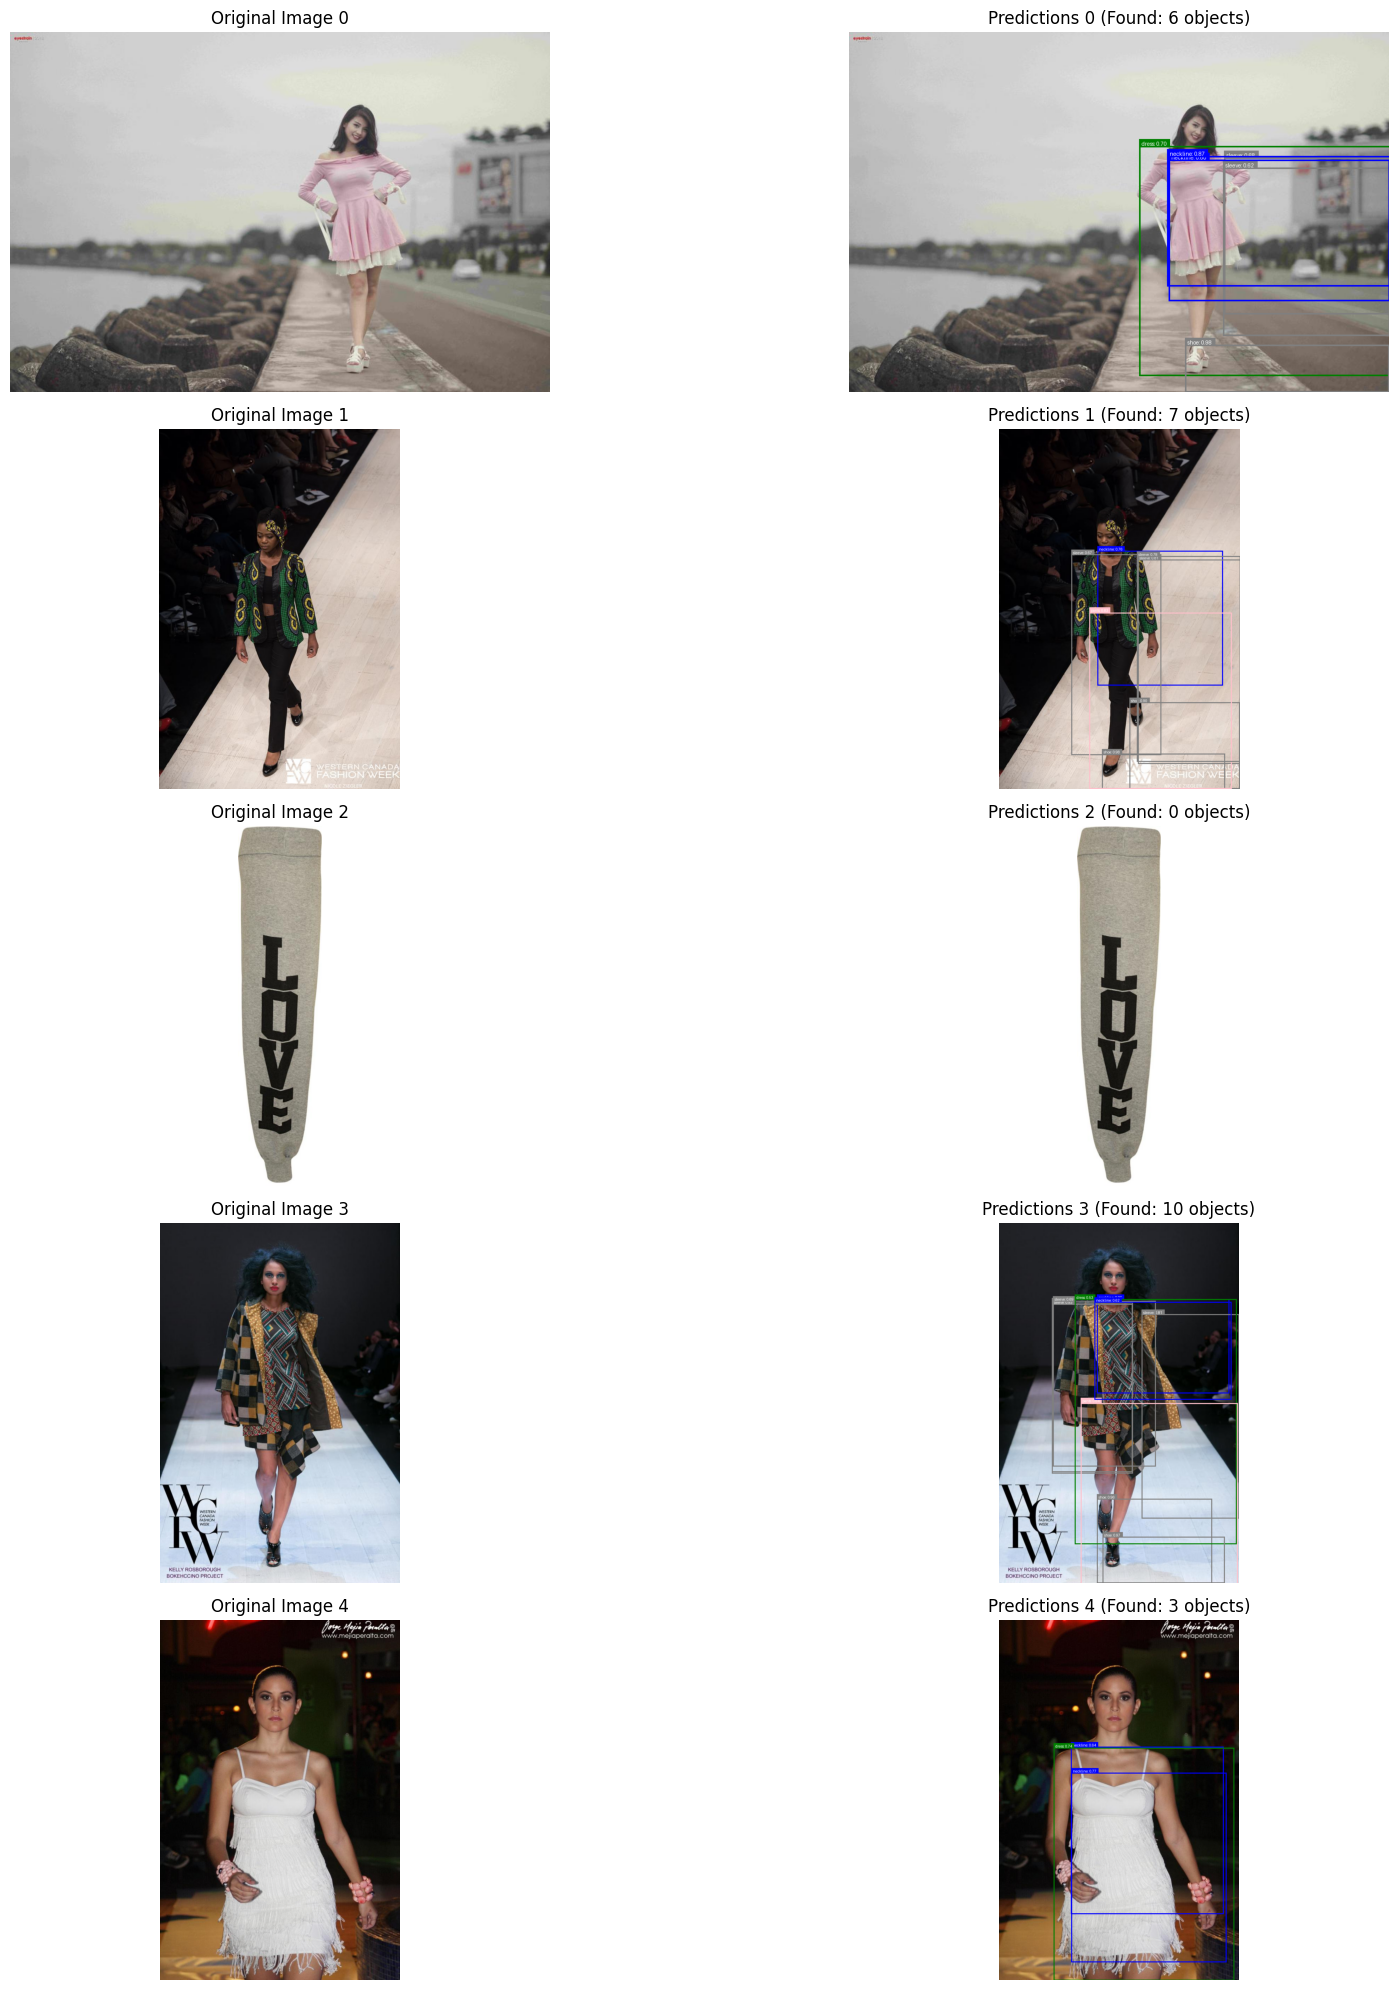

In [19]:
# Test on validation samples
print("Testing model on validation samples...")

# Get a few validation samples
test_indices = [0, 1, 2, 3, 4]

plt.figure(figsize=(20, 4*len(test_indices)))

for i, idx in enumerate(test_indices):
    # Get sample from appropriate dataset split
    if val_split_name:
        sample = dataset[val_split_name][idx]
    else:
        # If we created validation split from train data, get from val_dataset directly
        val_sample_idx = min(idx, len(val_dataset) - 1)
        # Get original sample - we need to access the underlying dataset
        if hasattr(val_dataset.dataset, 'select'):
            sample = val_dataset.dataset[val_sample_idx] 
        else:
            # Fallback to train dataset sample
            sample = dataset['train'][idx]
    
    image = sample['image']
    
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Make predictions
    predictions, viz_image = predict_and_visualize(model, image, processor, device, threshold=0.5)
    
    # Display results
    plt.subplot(len(test_indices), 2, i*2 + 1)
    plt.imshow(image)
    plt.title(f"Original Image {idx}", fontsize=12)
    plt.axis('off')
    
    plt.subplot(len(test_indices), 2, i*2 + 2)
    plt.imshow(viz_image)
    plt.title(f"Predictions {idx} (Found: {len(predictions['scores'])} objects)", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


# ============================================
# 6. Interactive Inference Demo
# ============================================


=== DEMO 1: Random Validation Image ===
Using sample image from validation set...
Image size: (682, 1024)
Making predictions...


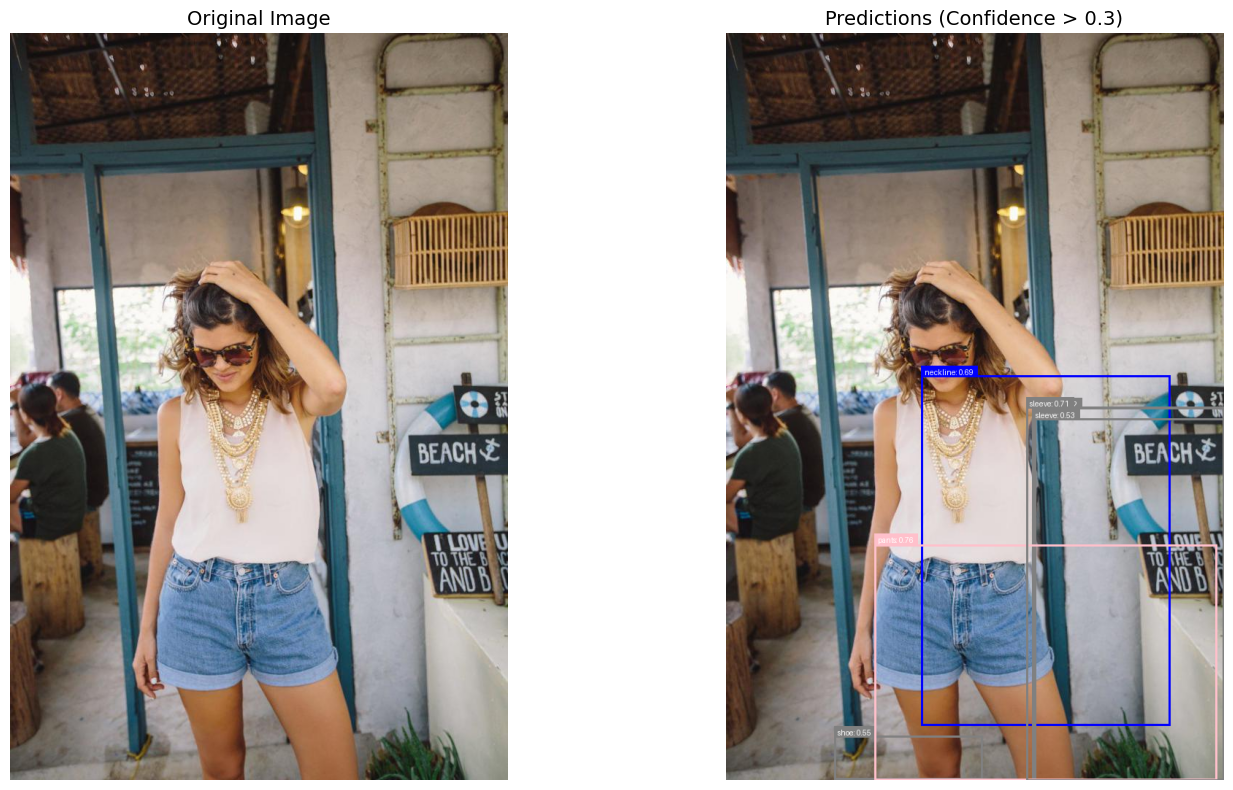


Detected 6 objects:
1. neckline: 0.686
2. sleeve: 0.719
3. shoe: 0.550
4. sleeve: 0.526
5. pants: 0.758
6. sleeve: 0.708

=== DEMO 2: Specific Validation Image ===
Using sample image from validation set...
Image size: (682, 1024)
Making predictions...


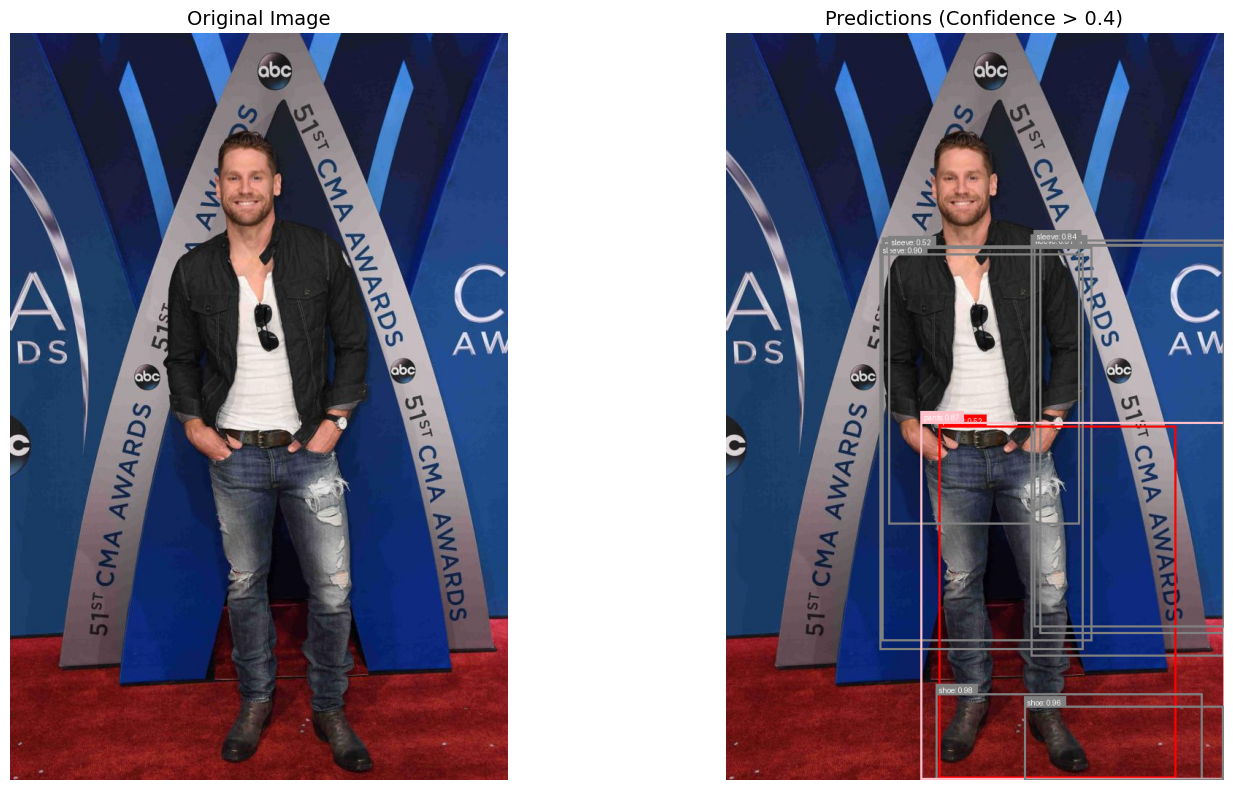


Detected 10 objects:
1. sleeve: 0.851
2. sleeve: 0.606
3. sleeve: 0.587
4. pocket: 0.518
5. sleeve: 0.903
6. shoe: 0.976
7. sleeve: 0.520
8. pants: 0.868
9. shoe: 0.956
10. sleeve: 0.841

=== DEMO 3: Custom Image Inference ===
To use your own image, modify the code cell above with your image path or URL
Saving model to ./fine_tuned_detr_fashionpedia...
Model saved successfully!
To load the model later, use:
model = DetrForObjectDetection.from_pretrained('./fine_tuned_detr_fashionpedia')
processor = AutoProcessor.from_pretrained('./fine_tuned_detr_fashionpedia')


In [20]:
# Interactive inference function
def inference_demo(image_path_or_url=None, threshold=0.5):
    """
    Interactive inference demo.
    
    Args:
        image_path_or_url: Path to local image or URL. If None, uses a default test image.
        threshold: Confidence threshold for displaying predictions
    """
    
    # If no image provided, use a sample from validation set
    if image_path_or_url is None:
        print("Using sample image from validation set...")
        # Use appropriate dataset split
        if val_split_name:
            available_samples = len(dataset[val_split_name])
            sample_idx = np.random.randint(available_samples)
            sample = dataset[val_split_name][sample_idx]
        else:
            # Use sample from our validation dataset
            sample_idx = np.random.randint(len(val_dataset))
            # Get from underlying dataset if possible
            if hasattr(val_dataset.dataset, 'select'):
                sample = val_dataset.dataset[sample_idx]
            else:
                sample = dataset['train'][sample_idx]
        
        image = sample['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')
    else:
        try:
            # Try to load image (works for both local paths and URLs)
            if image_path_or_url.startswith(('http://', 'https://')):
                import requests
                from io import BytesIO
                response = requests.get(image_path_or_url)
                image = Image.open(BytesIO(response.content)).convert('RGB')
            else:
                image = Image.open(image_path_or_url).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {e}")
            print("Using sample image instead...")
            # Use fallback sample
            if val_split_name:
                sample = dataset[val_split_name][0]
            else:
                sample = dataset['train'][0]
            image = sample['image']
            if image.mode != 'RGB':
                image = image.convert('RGB')
    
    print(f"Image size: {image.size}")
    
    # Make predictions
    print("Making predictions...")
    predictions, viz_image = predict_and_visualize(model, image, processor, device, threshold)
    
    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(viz_image)
    axes[1].set_title(f"Predictions (Confidence > {threshold})", fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction details
    print(f"\nDetected {len(predictions['scores'])} objects:")
    for i, (score, label, box) in enumerate(zip(predictions['scores'], 
                                               predictions['labels'], 
                                               predictions['boxes'])):
        if score > threshold:
            print(f"{i+1}. {id2label[label.item()]}: {score:.3f}")
    
    return predictions, viz_image

# %% [code]
# Demo 1: Random validation image
print("=== DEMO 1: Random Validation Image ===")
predictions1, viz1 = inference_demo(threshold=0.3)

# %% [code]
# Demo 2: Specific validation image
print("\n=== DEMO 2: Specific Validation Image ===")
predictions2, viz2 = inference_demo(threshold=0.4)

# %% [code]
# Demo 3: Custom image inference (uncomment and modify as needed)
"""
To use your own image, uncomment and modify one of these examples:

# Local image file:
# predictions3, viz3 = inference_demo("/path/to/your/image.jpg", threshold=0.5)

# Image from URL:
# predictions3, viz3 = inference_demo("https://example.com/fashion_image.jpg", threshold=0.5)
"""

print("\n=== DEMO 3: Custom Image Inference ===")
print("To use your own image, modify the code cell above with your image path or URL")



In [25]:
import ipywidgets as widgets
from IPython.display import display
import tempfile

# Upload widget
upload_btn = widgets.FileUpload(accept='image/*', multiple=False)
out = widgets.Output()

def on_upload_change(change):
    out.clear_output()
    with out:
        if upload_btn.value:
            for file_info in upload_btn.value:  # ✅ works in Kaggle
                filename = file_info['name']
                print(f"Uploaded: {filename}")
                
                # Save temporarily
                temp_path = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg").name
                with open(temp_path, "wb") as f:
                    f.write(file_info['content'])
                
                # Run inference
                predictions, viz = inference_demo(temp_path, threshold=0.5)
                return predictions, viz

upload_btn.observe(on_upload_change, names='value')
display(upload_btn, out)


FileUpload(value=(), accept='image/*', description='Upload')

Output()

In [21]:
# %% [markdown]
# ## 7. Save the Fine-tuned Model

# %% [code]
# Save the fine-tuned model
model_save_path = "./fine_tuned_detr_fashionpedia"
print(f"Saving model to {model_save_path}...")

model.save_pretrained(model_save_path)
processor.save_pretrained(model_save_path)

print("Model saved successfully!")
print(f"To load the model later, use:")
print(f"model = DetrForObjectDetection.from_pretrained('{model_save_path}')")
print(f"processor = AutoProcessor.from_pretrained('{model_save_path}')")


Saving model to ./fine_tuned_detr_fashionpedia...
Model saved successfully!
To load the model later, use:
model = DetrForObjectDetection.from_pretrained('./fine_tuned_detr_fashionpedia')
processor = AutoProcessor.from_pretrained('./fine_tuned_detr_fashionpedia')
